<a href="https://colab.research.google.com/github/rydr0/Sat_Image_Dataset/blob/master/Visualization_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro and References

Note - all data and helper files used in this analysis are available at: https://github.com/rydr0/Sat_Image_Dataset
This notebook is designed to be used on Google Colab and files from that repository are cloned to Colab's storage.


Packages Used and Works Consulted:

\begin{enumerate}
\item PyTorch Documentation - https://pytorch.org/docs/stable/index.html
\item Imbalanced Dataset Sampler - https://github.com/ufoym/imbalanced-dataset-sampler
\item Shapefile dataframes and visualisation using GeoPandas - https://geopandas.org/
\item NN summary with pytorch-summary https://github.com/sksq96/pytorch-summary
\item Confusion matrices -  https://www.kaggle.com/agungor2/various-confusion-matrix-plots
\item scikit-learn for metrics and image processing - https://scikit-learn.org/stable/modules/classes.html
\item matplotlib changing font sizes - https://stackoverflow.com/a/39566040
\item display_layer_activations functions - https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/ 
and https://cs231n.github.io/understanding-cnn/
\item Model Training Loops from Pytorch Ignite - https://pytorch.org/ignite/
\item GDAL documentation for splitting images - https://gdal.org/
\item Calculating class weights: make_weights_for_balanced_classes - https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/3
\item VGG Pytorch Implementation - https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
\item Google Earth Engine Python API -https://developers.google.com/earth-engine/guides
\item Folium for Earth Engine Visualiation - https://python-visualization.github.io/folium/

\end{enumerate}


# Imports



In [ ]:
# Check which GPU using on Google colab
!nvidia-smi

Fri Sep 11 04:57:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHnYp5IKClHNdTA2MuV71HMQZp5sasehlaWj-6F8XssO2-v9Cx7OYI
Mounted at /content/drive


In [ ]:
# Load Github Repository with Satellite Images, Population Labels and Helper files
! git clone https://github.com/rydr0/Sat_Image_Dataset.git

Cloning into 'Sat_Image_Dataset'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 138637 (delta 50), reused 62 (delta 23), pack-reused 138545
Receiving objects: 100% (138637/138637), 1.35 GiB | 23.84 MiB/s, done.
Resolving deltas: 100% (71332/71332), done.
Checking out files: 100% (92905/92905), done.


In [ ]:
# Install third-party libraries
!pip install pytorch.ignite
!pip install geopandas
!pip install gdal

     |████████████████████████████████| 174kB 3.3MB/s 
     |████████████████████████████████| 972kB 3.4MB/s 
     |████████████████████████████████| 14.8MB 211kB/s 
     |████████████████████████████████| 10.9MB 66.9MB/s 


In [ ]:
# Setup so that plots use LaTex font
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-s

In [ ]:
# Import packages
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import geopandas as gpd
import gdal
import pprint

%matplotlib inline

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load functions from Helper Files
sys.path.append('/content/Sat_Image_Dataset')
from DatasetandDataLoader import *
from Helpers import *
from Training_Classification import *
from Visualisation import *
from Neural_Network import *

# Load Datasets

In [ ]:
# Load 16 class dataset
train_dataset_16classes, test_dataset_16classes, sat_mean, sat_std = load_datasets(
    flip=False)

Mean for image channels:
tensor([[[[ 481.4347]],

         [[ 661.0318]],

         [[ 633.2782]],

         [[2610.5615]],

         [[1754.3627]],

         [[2808.4644]],

         [[ 987.0544]]]], dtype=torch.float64)
Standard deviation for image channels:
tensor([[[[182.0427]],

         [[221.7736]],

         [[282.7514]],

         [[989.6967]],

         [[604.5539]],

         [[463.1821]],

         [[403.9931]]]], dtype=torch.float64)
NAN pixel values found and replaced:1944166
Percentage of total pixels:0.026875179981978577
Training Set Images: 37994
NAN pixel values found and replaced:442414
Percentage of total pixels:0.025244303949147805
Test Set Images: 8450


In [ ]:
# Load 6 class dataset
train_dataset_6classes, test_dataset_6classes, _, _ = load_datasets(flip=False, classes=6)

Mean for image channels:
tensor([[[[ 481.4347]],

         [[ 661.0318]],

         [[ 633.2782]],

         [[2610.5615]],

         [[1754.3627]],

         [[2808.4644]],

         [[ 987.0544]]]], dtype=torch.float64)
Standard deviation for image channels:
tensor([[[[182.0427]],

         [[221.7736]],

         [[282.7514]],

         [[989.6967]],

         [[604.5539]],

         [[463.1821]],

         [[403.9931]]]], dtype=torch.float64)
NAN pixel values found and replaced:1944166
Percentage of total pixels:0.026875179981978577
Training Set Images: 37994
NAN pixel values found and replaced:442414
Percentage of total pixels:0.025244303949147805
Test Set Images: 8450


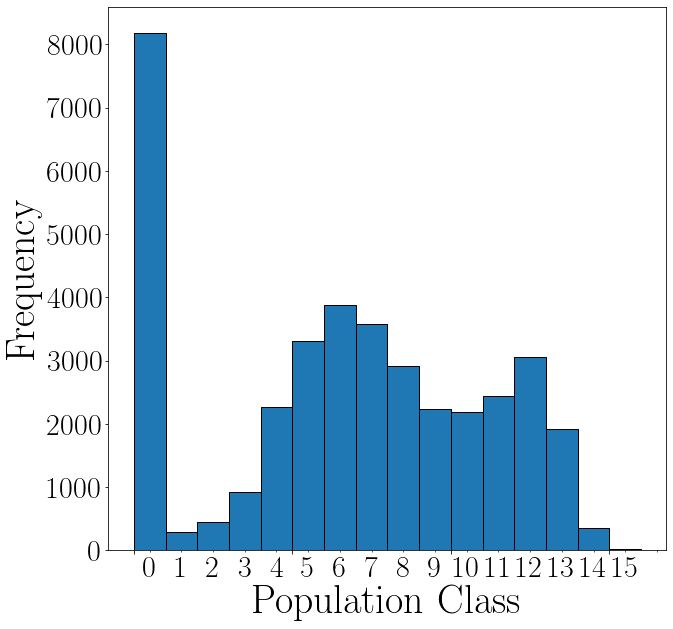

In [ ]:
# Plot Training Set 16 class histogram
hist2 = class_hist(train_dataset_16classes, figsize=(10,10))
plt.ylabel("Frequency")
plt.xlabel("Population Class")
plt.show()

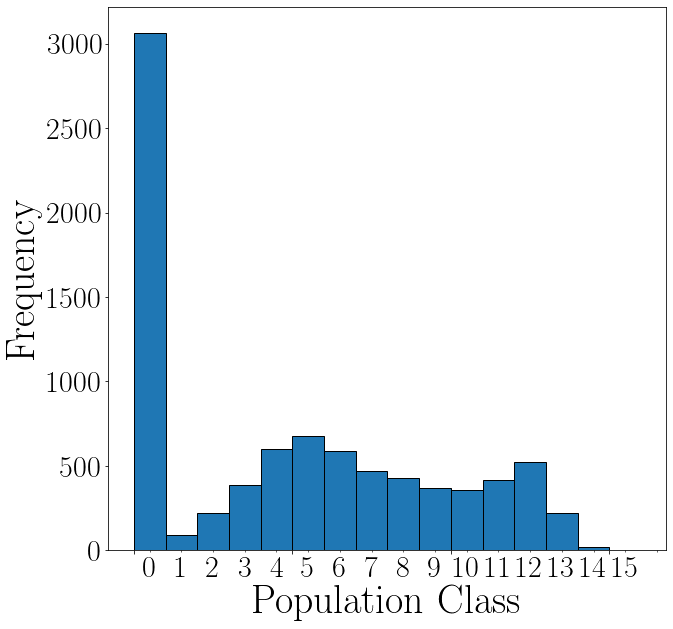

In [ ]:
# Plot Test Set 16 class histogram
hist2 = class_hist(test_dataset_16classes, figsize=(10,10))
plt.ylabel("Frequency")
plt.xlabel("Population Class")
plt.show()

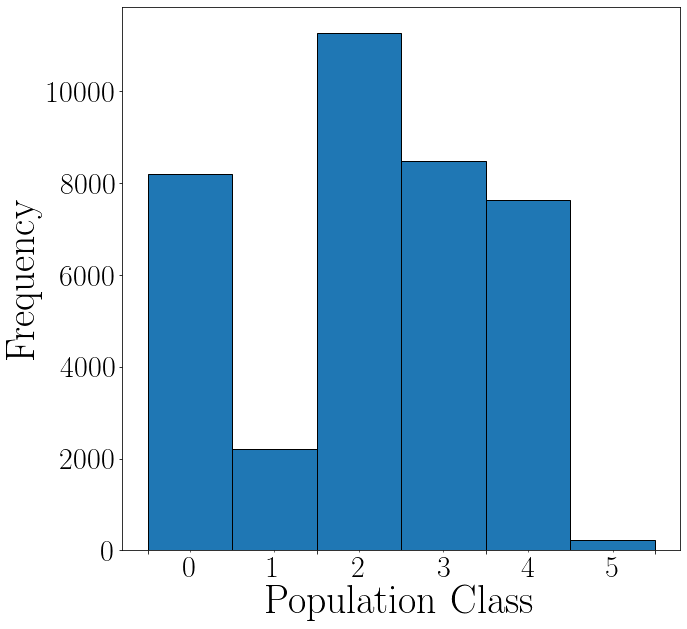

In [ ]:
# Plot Training Set 16 class histogram
hist2 = class_hist(train_dataset_6classes, figsize=(10,10), classes=6)
plt.ylabel("Frequency")
plt.xlabel("Population Class")
plt.show()

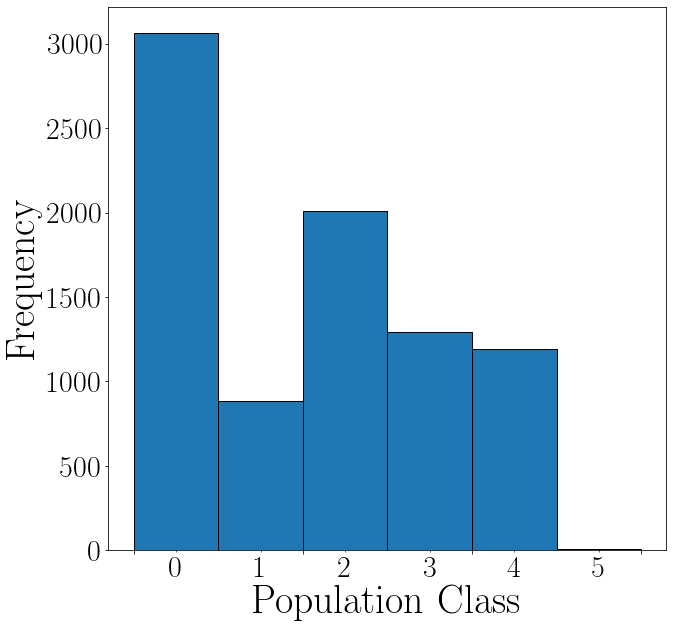

In [ ]:
# Plot Test Set 6 class histogram
hist2 = class_hist(test_dataset_6classes, figsize=(10,10), classes=6)
plt.ylabel("Frequency")
plt.xlabel("Population Class")
plt.show()

# Visualization of Training Satellite Images

In [ ]:
vis_seed = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


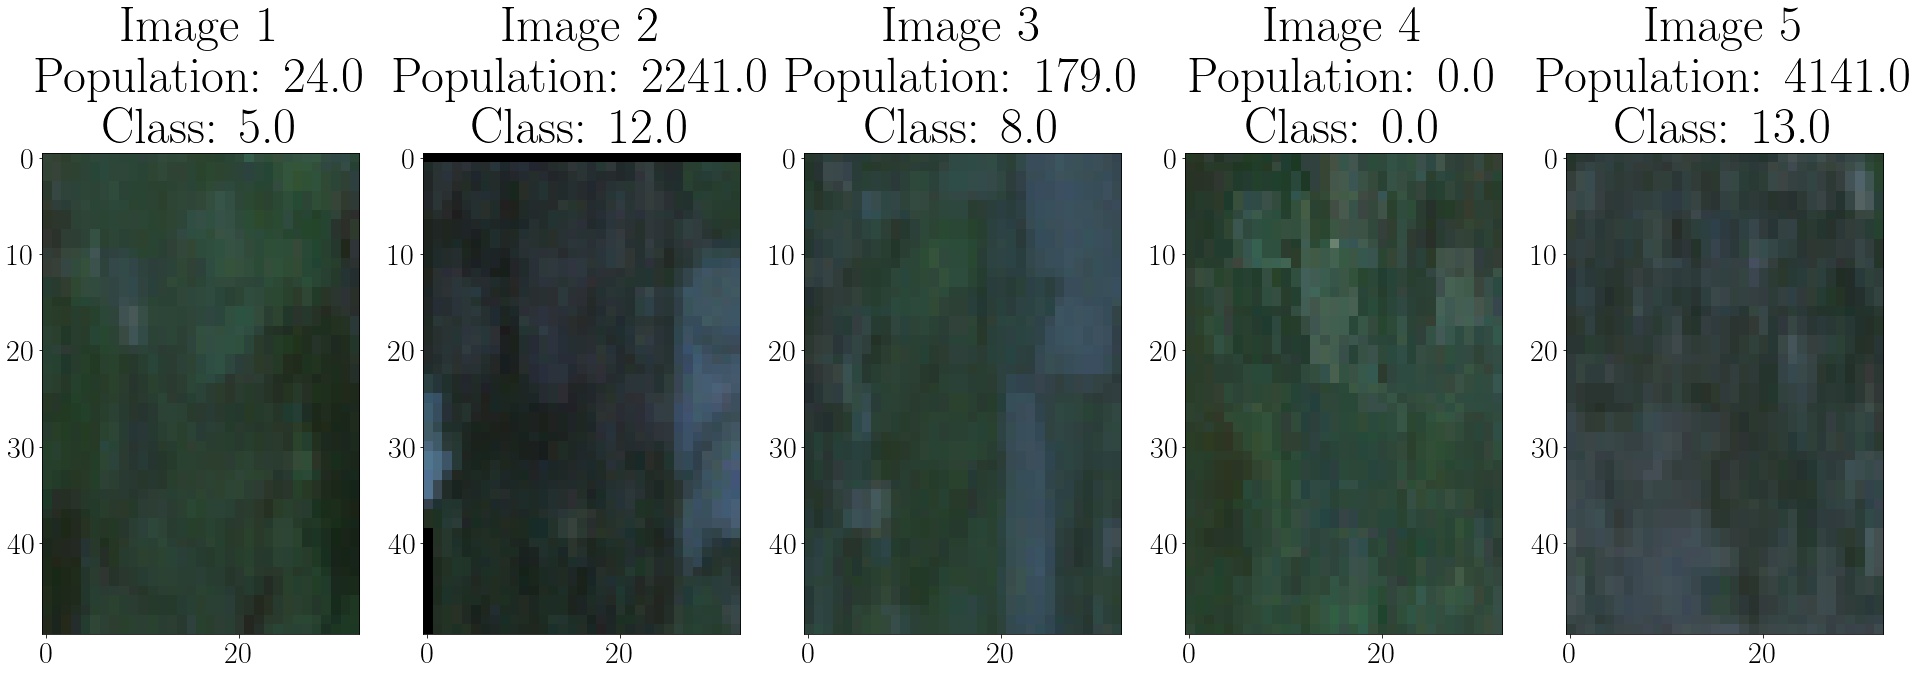

<Figure size 432x288 with 0 Axes>

In [ ]:
show_images((0,1,2), None, train_dataset_16classes, vis_seed, sat_mean, sat_std) # RGB Image (Bands 1, 2, 3)

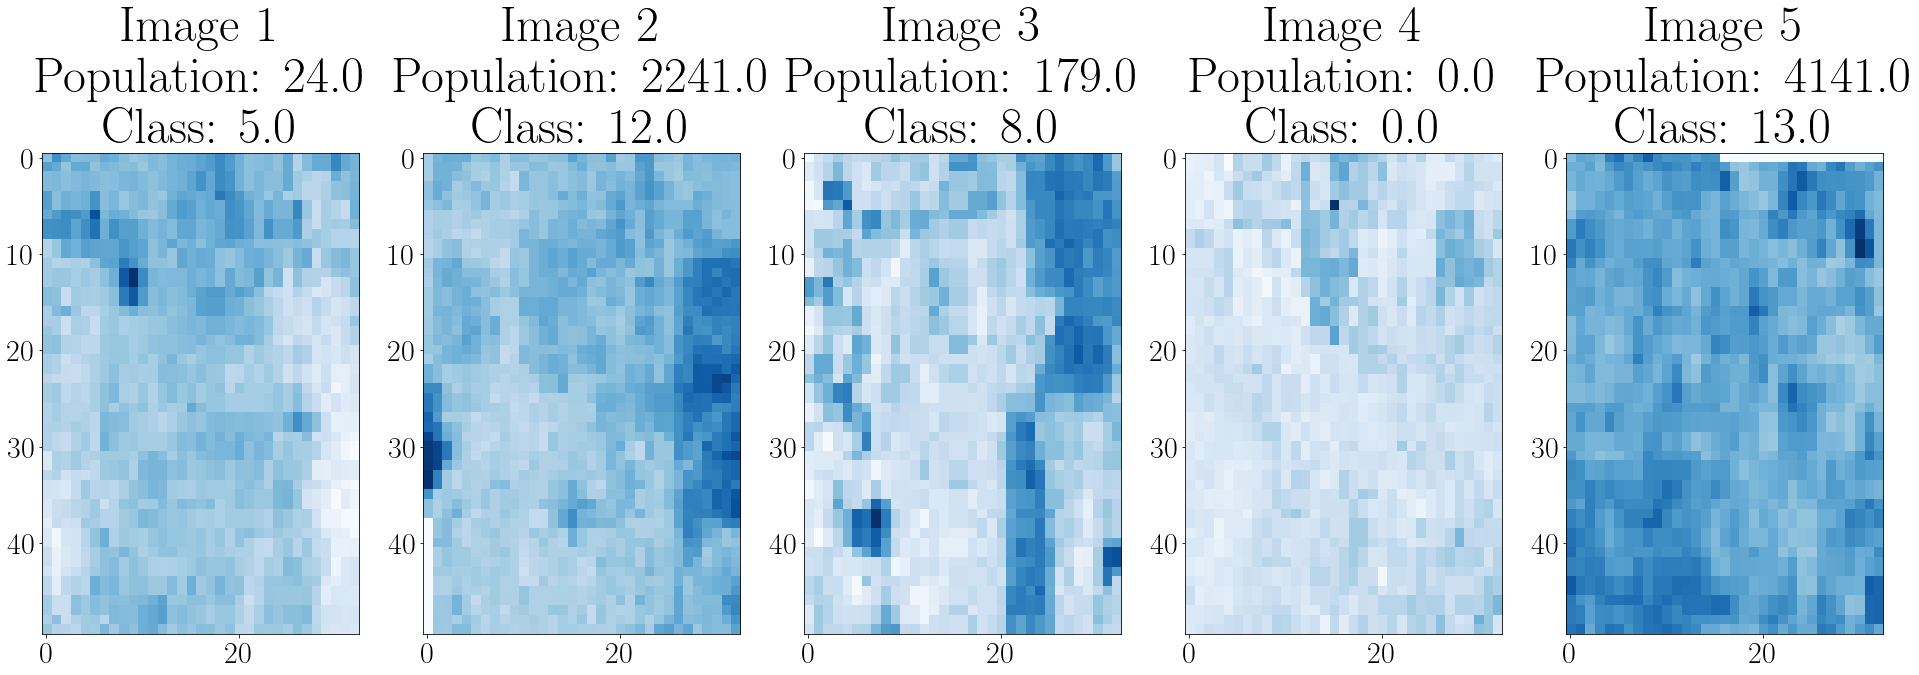

<Figure size 432x288 with 0 Axes>

In [ ]:
show_images(0, "Blues", train_dataset_16classes, vis_seed, sat_mean, sat_std) # Band 1 (blue) surface reflectance

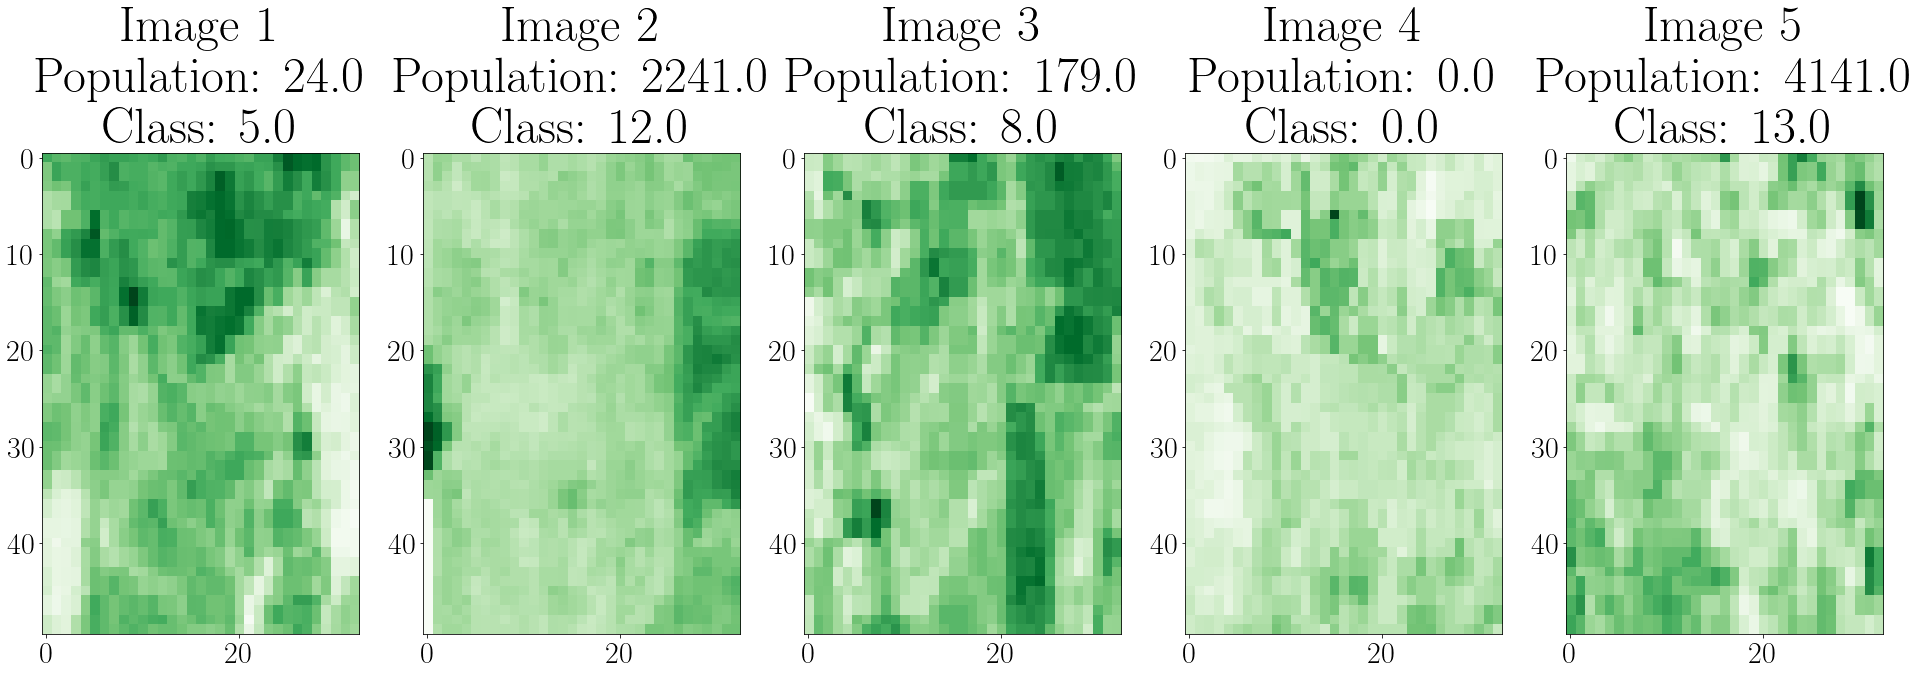

<Figure size 432x288 with 0 Axes>

In [ ]:
show_images(1, "Greens", train_dataset_16classes, vis_seed, sat_mean, sat_std) # Band 2 (green) surface reflectance

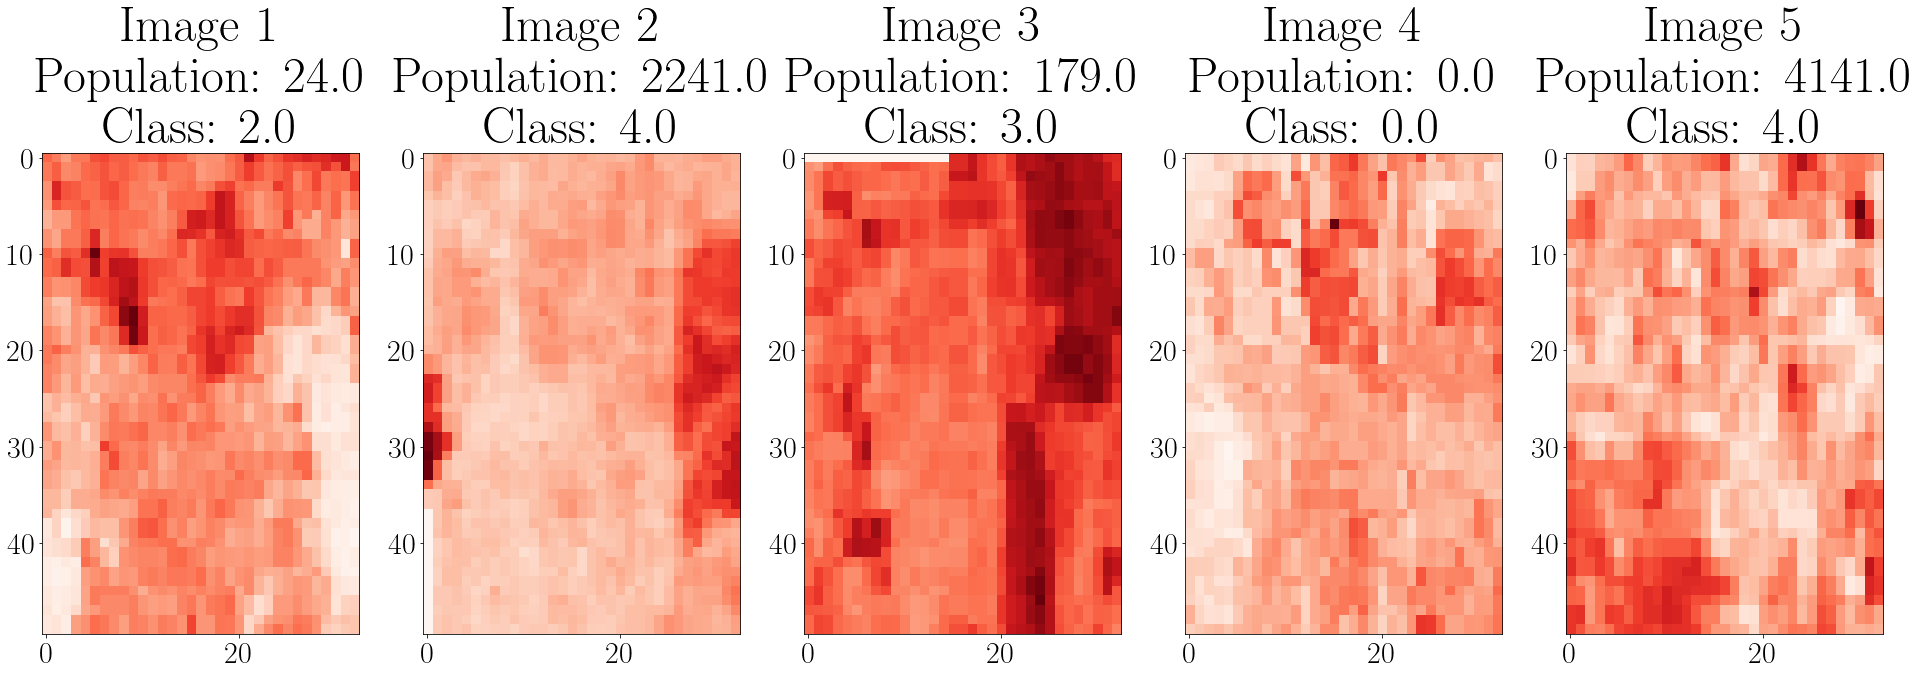

<Figure size 432x288 with 0 Axes>

In [ ]:
show_images(2, "Reds", train_dataset_6classes, vis_seed, sat_mean, sat_std) # Band 3 (red) surface reflectance

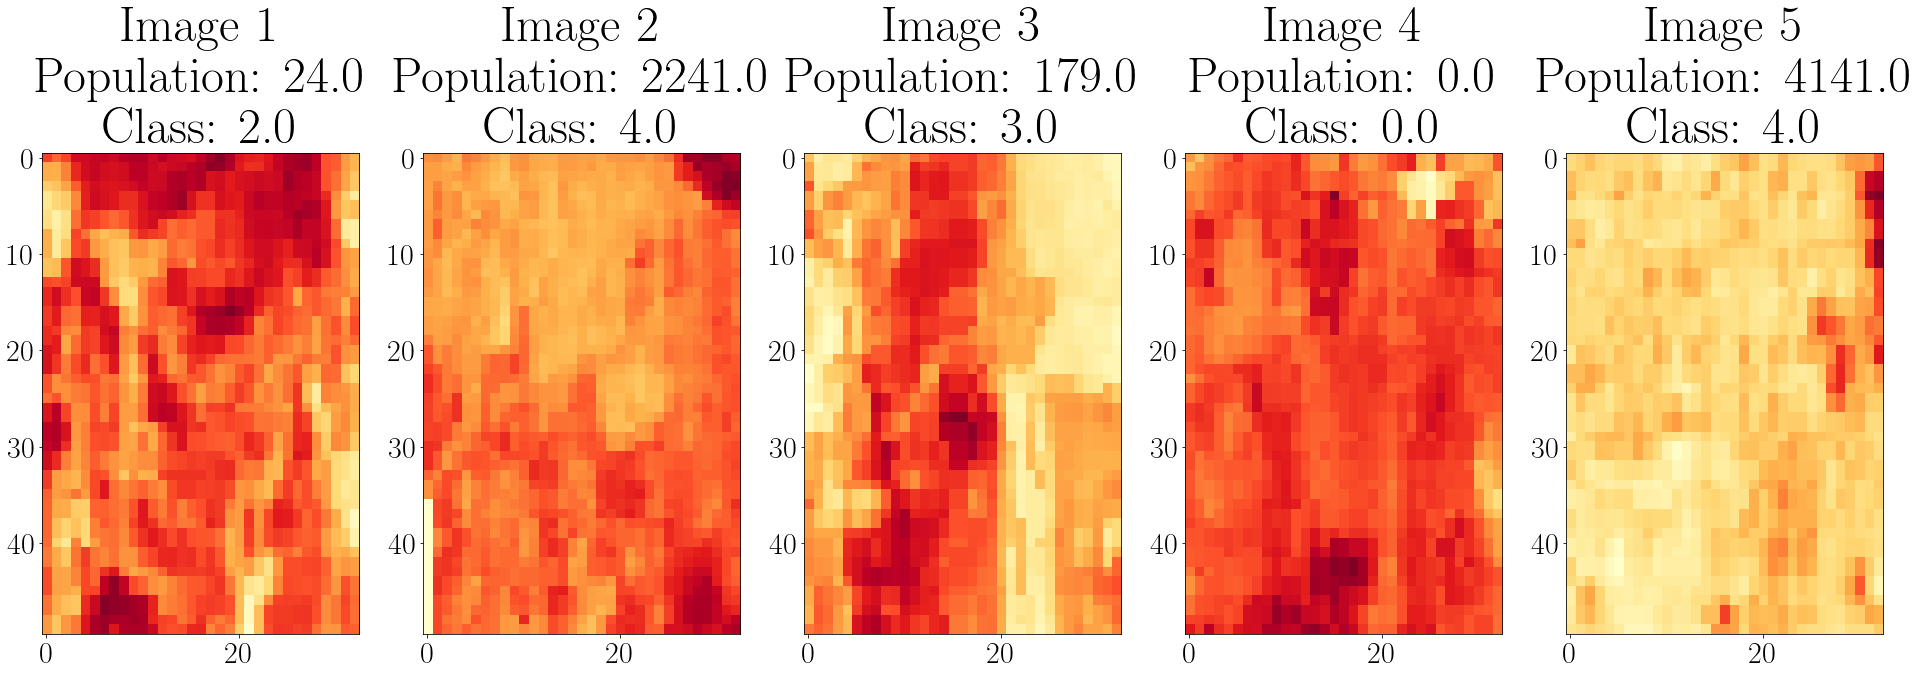

<Figure size 432x288 with 0 Axes>

In [ ]:
show_images(3, "YlOrRd", train_dataset_6classes, vis_seed, sat_mean, sat_std) # Band 4 (near infrared) surface reflectance

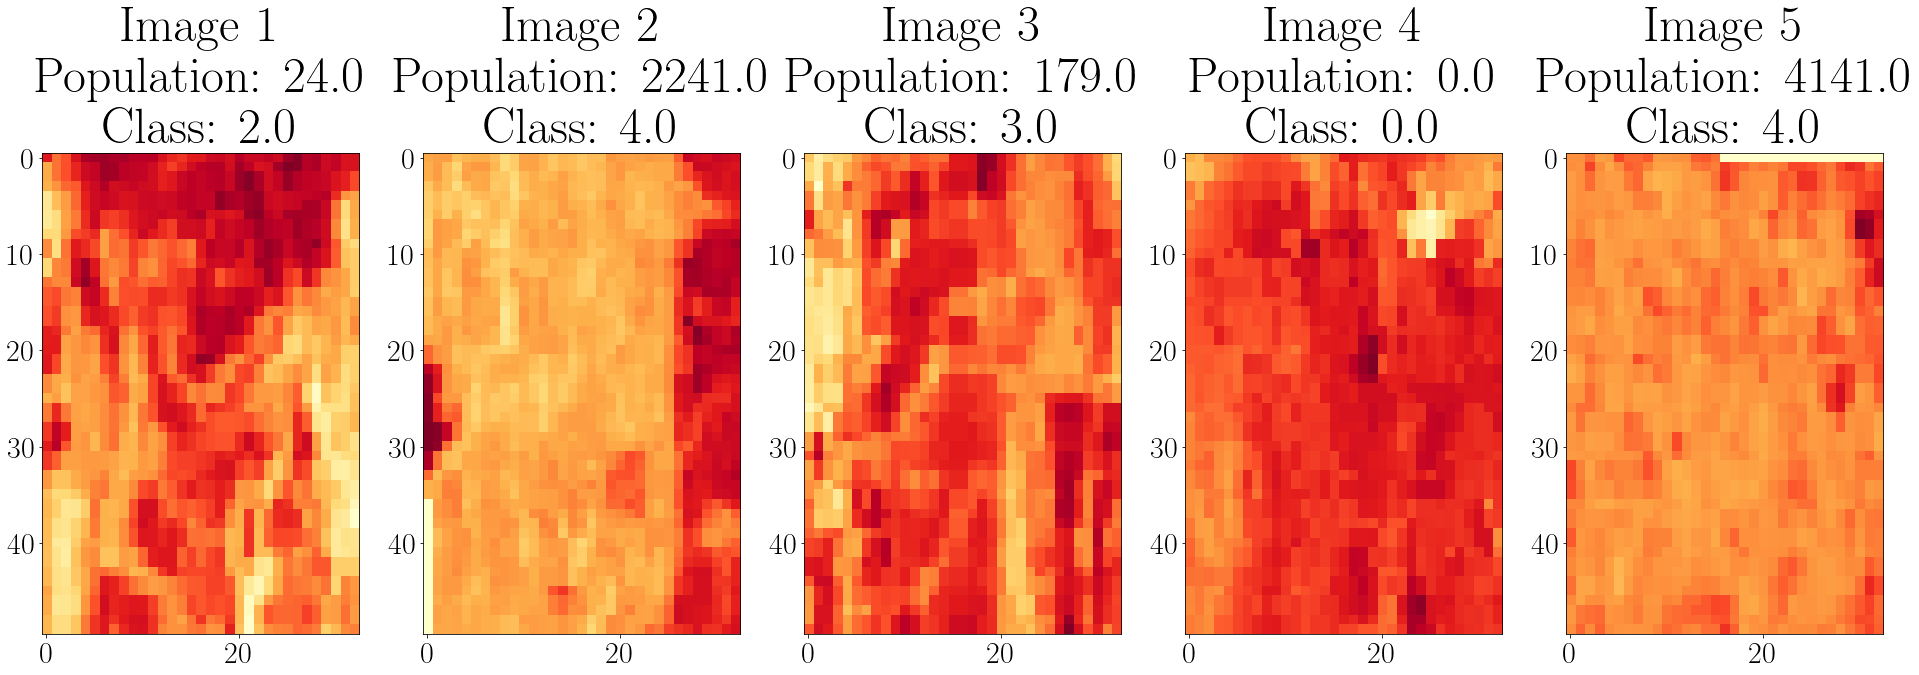

<Figure size 432x288 with 0 Axes>

In [ ]:
show_images(4, "YlOrRd", train_dataset_6classes, vis_seed, sat_mean, sat_std) # Band 5 (shortwave infrared 1) surface reflectance

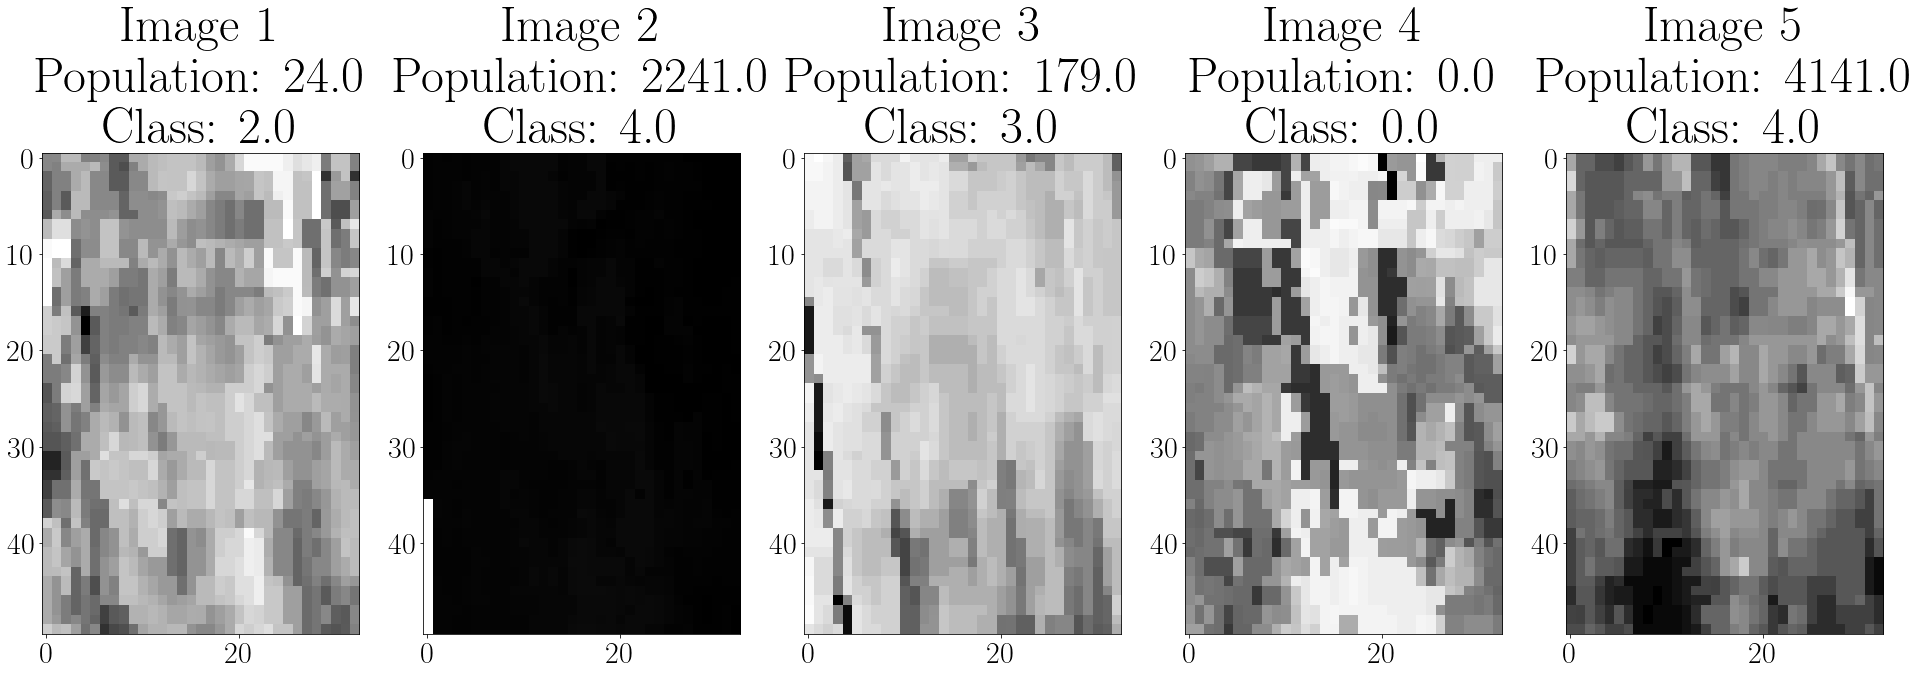

<Figure size 432x288 with 0 Axes>

In [ ]:
show_images(5, "Greys", train_dataset_6classes, vis_seed, sat_mean, sat_std) # Band 6 brightness temperature

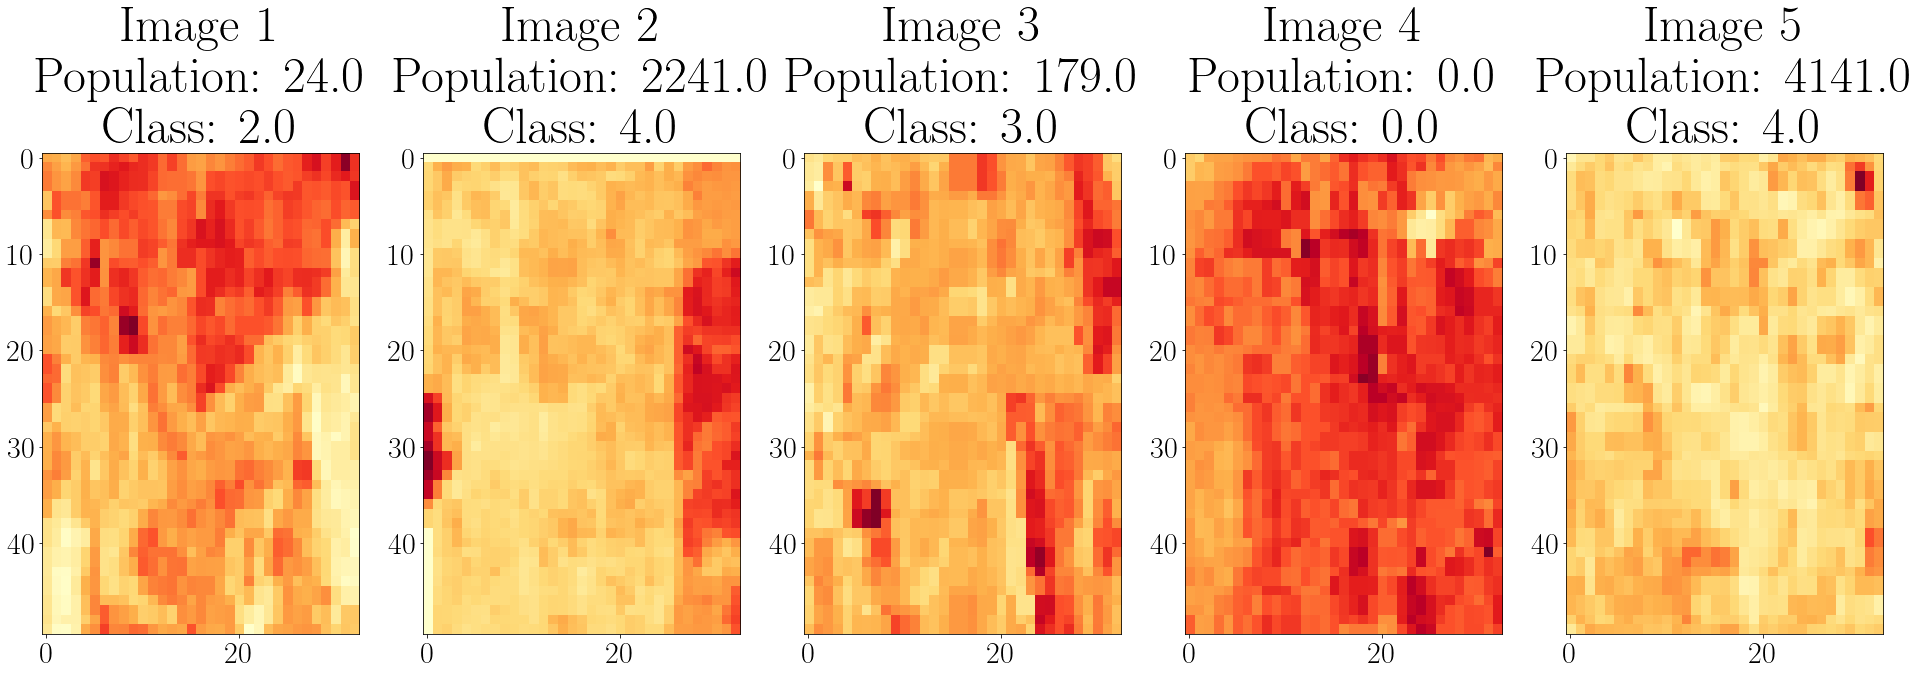

<Figure size 432x288 with 0 Axes>

In [ ]:
show_images(6, "YlOrRd", train_dataset_6classes, vis_seed, sat_mean, sat_std) #Band 7 (shortwave infrared 2) surface reflectance

# Load Saved Models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model A - 16 classes
model_cl = Neural_Network(config='16', batch_norm=True)
parameters = torch.load(
    "/content/drive/My Drive/Dissertation Files/Models/16layersflip_LowestLossEpoch33")
model_cl.load_state_dict(parameters['model'])
model_cl = model_cl.float()
model_cl.to(device)
model_cl.eval()

# Model B - 6 classes
model_cl6 = Neural_Network(config='16', batch_norm=True, mode='cla-6')
parameters = torch.load(
    "/content/drive/My Drive/Dissertation Files/Models/classification_6classes_pretrained")
model_cl6.load_state_dict(parameters['model'])
model_cl6 = model_cl6.float()
model_cl6.to(device)
model_cl6.eval()

# Model C - Regression
model_reg = Neural_Network(config='16', batch_norm=True, mode='reg')
parameters = torch.load(
    "/content/drive/My Drive/Dissertation Files/Models/regl1_LowestLossEpoch28")
model_reg.load_state_dict(parameters['model'])
model_reg = model_reg.float()
model_reg.to(device)
model_reg.eval()


print(model_cl.state_dict().keys())

odict_keys(['convs.0.weight', 'convs.0.bias', 'convs.1.weight', 'convs.1.bias', 'convs.1.running_mean', 'convs.1.running_var', 'convs.1.num_batches_tracked', 'convs.3.weight', 'convs.3.bias', 'convs.4.weight', 'convs.4.bias', 'convs.4.running_mean', 'convs.4.running_var', 'convs.4.num_batches_tracked', 'convs.7.weight', 'convs.7.bias', 'convs.8.weight', 'convs.8.bias', 'convs.8.running_mean', 'convs.8.running_var', 'convs.8.num_batches_tracked', 'convs.10.weight', 'convs.10.bias', 'convs.11.weight', 'convs.11.bias', 'convs.11.running_mean', 'convs.11.running_var', 'convs.11.num_batches_tracked', 'convs.14.weight', 'convs.14.bias', 'convs.15.weight', 'convs.15.bias', 'convs.15.running_mean', 'convs.15.running_var', 'convs.15.num_batches_tracked', 'convs.17.weight', 'convs.17.bias', 'convs.18.weight', 'convs.18.bias', 'convs.18.running_mean', 'convs.18.running_var', 'convs.18.num_batches_tracked', 'convs.20.weight', 'convs.20.bias', 'convs.21.weight', 'convs.21.bias', 'convs.21.running_m

# Testing model

## Testing model predictions

### Model A - 16 classes

In [ ]:
# Get results on training set
results_cl_train = test_classification(model_cl, train_dataset_16classes,
                                       train_dataset_16classes.n_images,
                                       device)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Accuracy (Top 1, Top 2, Top 3): 52.679370%, 63.349476%, 67.955467%
    
Accuracy: 52.68%
    
Balanced Accuracy: 39.03%
    
F1 Score: 0.49
    

    
              precision    recall  f1-score   support

         0.0       0.65      0.92      0.76      8185
         1.0       0.00      0.00      0.00       290
         2.0       0.00      0.00      0.00       446
         3.0       0.00      0.00      0.00       921
         4.0       0.00      0.00      0.00      2266
         5.0       0.28      0.51      0.36      3311
         6.0       0.34      0.44      0.38      3883
         7.0       0.35      0.21      0.26      3572
         8.0       0.47      0.29      0.35      2916
         9.0       0.48      0.52      0.50      2237
        10.0       0.72      0.32      0.44      2182
        11.0       0.65      0.83      0.73      2440
        12.0       0.84      0.62      0.71      3055
        13.0       0.68      0.75      0.71      1912
        14.0       0.51      0

In [ ]:
# Get results on test set
results_cl_test = test_classification(model_cl, test_dataset_16classes,
                                      test_dataset_16classes.n_images, device)

Overall Accuracy (Top 1, Top 2, Top 3): 49.278107%, 59.408284%, 64.769231%
    
Accuracy: 49.28%
    
Balanced Accuracy: 32.45%
    
F1 Score: 0.44
    

    
              precision    recall  f1-score   support

         0.0       0.65      0.87      0.74      3065
         1.0       0.00      0.00      0.00        92
         2.0       0.00      0.00      0.00       222
         3.0       0.00      0.00      0.00       388
         4.0       0.00      0.00      0.00       600
         5.0       0.20      0.35      0.25       680
         6.0       0.26      0.37      0.31       591
         7.0       0.21      0.15      0.17       473
         8.0       0.37      0.22      0.27       428
         9.0       0.38      0.40      0.38       372
        10.0       0.48      0.23      0.31       355
        11.0       0.50      0.59      0.54       418
        12.0       0.73      0.44      0.55       522
        13.0       0.55      0.70      0.61       221
        14.0       0.59      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Convert classification result to population using midpoints
results_cl_test_to_pop = classes_to_population(results_cl_test,
                                               test_dataset_16classes,
                                               classes=16)

Actual Total Population for Region: 4113870
          
Predicted Total Population for Region: 4130976.0
          
Actual Mean Population for Region: 486.8485207100592
          
Predicted Mean Population for Region: 488.872899408284
          
MAE: 205.97
          
%MAE: 42.31
          
RMSE: 604.59
          
R^2: 0.7506
          
Explained Variance: 0.7506


### Model B - 6 classes

In [ ]:
# Get results on training set
results_cl6_train = test_classification(model_cl6, train_dataset_6classes,
                                        train_dataset_6classes.n_images,
                                        device)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Accuracy (Top 1, Top 2, Top 3): 78.328157%, 88.850871%, 92.406696%
    
Accuracy: 78.33%
    
Balanced Accuracy: 66.40%
    
F1 Score: 0.76
    

    
              precision    recall  f1-score   support

         0.0       0.86      0.74      0.79      8185
         1.0       0.00      0.00      0.00      2204
         2.0       0.65      0.87      0.74     11271
         3.0       0.82      0.78      0.80      8474
         4.0       0.94      0.94      0.94      7631
         5.0       0.80      0.66      0.72       229

    accuracy                           0.78     37994
   macro avg       0.68      0.66      0.67     37994
weighted avg       0.75      0.78      0.76     37994



In [ ]:
# Get results on test set
results_cl6_test = test_classification(model_cl6, test_dataset_6classes,
                                       test_dataset_6classes.n_images, device)

Overall Accuracy (Top 1, Top 2, Top 3): 66.745562%, 80.863905%, 88.461538%
    
Accuracy: 66.75%
    
Balanced Accuracy: 50.63%
    
F1 Score: 0.64
    

    
              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75      3065
         1.0       0.00      0.00      0.00       886
         2.0       0.46      0.76      0.57      2008
         3.0       0.71      0.67      0.69      1292
         4.0       0.91      0.90      0.91      1192
         5.0       0.00      0.00      0.00         7

    accuracy                           0.67      8450
   macro avg       0.48      0.51      0.49      8450
weighted avg       0.63      0.67      0.64      8450



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Convert classification to population
results_cl6_test_to_pop = classes_to_population(results_cl6_test,
                                                test_dataset_6classes,
                                                classes=6)

Actual Total Population for Region: 4113870
          
Predicted Total Population for Region: 7305640.0
          
Actual Mean Population for Region: 486.8485207100592
          
Predicted Mean Population for Region: 864.5727810650887
          
MAE: 465.90
          
%MAE: 95.70
          
RMSE: 1174.78
          
R^2: 0.0583
          
Explained Variance: 0.1556


### Model C - Regression

In [ ]:
results_reg_train = test_regression(model_reg, train_dataset_16classes,
                                    train_dataset_16classes.n_images, device)

Actual Total Population for Region: 30889244
          
Predicted Total Population for Region: 32441766
          
Actual Mean Population for Region: 813.003211033321
          
Predicted Mean Population for Region: 853.8655050797495
          
MAE: 187.79
          
%MAE: 23.10
          
RMSE: 489.00
          
R^2: 0.9239
          
Explained Variance: 0.9244


In [ ]:
results_reg_test = test_regression(model_reg, test_dataset_16classes,
                                   test_dataset_16classes.n_images, device)

Actual Total Population for Region: 4113870
          
Predicted Total Population for Region: 4377798
          
Actual Mean Population for Region: 486.8485207100592
          
Predicted Mean Population for Region: 518.0826035502959
          
MAE: 152.36
          
%MAE: 31.29
          
RMSE: 426.42
          
R^2: 0.8759
          
Explained Variance: 0.8766


## Individual prediction confidence

In [ ]:
# Create individual image and label loader
loader = torch.utils.data.DataLoader(test_dataset_16classes,
                                         batch_size=1,
                                         shuffle=False)
iter_loader = iter(loader)

# Softmax activation required to determine prediction confidence
softmax = torch.nn.Softmax(dim=1)

In [ ]:
# Choose an image from the dataset
images, labels = iter_loader.next()
images = images.float()
images, labels = images.to(device), labels.to(device)
model_cl.eval()

# Calculate raw predictions using 16 class classification model
with torch.no_grad():
    outputs = model_cl(images)

# Print prediction, true population and class, 
# and confidence for each label
_, pred = torch.max(outputs, dim=1)
print("""True Population: {:.0f}
True Population Class: {:.0f}
Prediction: {} with {:.2f}% certainty\n""".format(
    labels.view(-1)[1],
    labels.view(-1)[2], pred.item(),
    softmax(outputs)[0, pred.item()] * 100))
for i in range(0, outputs.shape[1]):
    print("Probability of class {}: {:.2f}%".format(
        i,
        softmax(outputs)[0, i] * 100))

True Population: 4179
True Population Class: 13
Prediction: 13 with 15.67% certainty

Probability of class 0: 3.64%
Probability of class 1: 1.36%
Probability of class 2: 1.15%
Probability of class 3: 2.13%
Probability of class 4: 3.03%
Probability of class 5: 4.89%
Probability of class 6: 5.83%
Probability of class 7: 7.17%
Probability of class 8: 6.05%
Probability of class 9: 5.91%
Probability of class 10: 8.01%
Probability of class 11: 10.49%
Probability of class 12: 14.41%
Probability of class 13: 15.67%
Probability of class 14: 7.94%
Probability of class 15: 2.33%


## Top 4 images for each class

In [ ]:
# Create another individual image loader
loader = torch.utils.data.DataLoader(test_dataset_16classes,
                                     batch_size=1,
                                     shuffle=False)
iter_loader = iter(loader)
image_pred_confidence = []

# iterate through all images and produce outputs
for num in range(0, len(test_dataset_16classes)):

    images, labels = iter_loader.next()
    images = images.float()
    images, labels = images.to(device), labels.to(device)
    model_cl.eval()
    with torch.no_grad():
        outputs = model_cl(images)

        _, pred = torch.max(outputs, dim=1)
    
    # calcualate confidence for each prediction and store in a list
    confidence = softmax(outputs)[0, pred.item()]

    image_pred_confidence.append([images, pred, confidence, labels])

In [ ]:
# Store each classes predictions and confidence in a dict
print(len(image_pred_confidence))
class_images = {}
for c in range(0, 18):
    class_images["Class {}".format(c)] = [
        el for el in image_pred_confidence if el[1] == c
    ]

8450


In [ ]:
def key_func(list):
    """Function for soting class prediction lists by confidence"""
    return list[2].item()

In [ ]:
# Sort each class with highest confidence values first
top_10_images = {}
for c in range(0, 18):
    key = "Class {}".format(c)
    if len(class_images[key]) >= 10:
        class_images[key].sort(reverse=True, key=key_func)
        top_10_images[key] = class_images[key][0:10]
    else:
        top_10_images[key] = class_images[key]

In [ ]:
def plot_top_4_images(class_number,
                      im_list=top_10_images,
                      sat_mean=sat_mean,
                      sat_std=sat_std):
    """Plots the top 4 images for selected class
    Arguments:
        class_number (int) - class to visualise
        im_list - the dictionary containing top 10 images for each class
        sat_mean, sat_std - mean and standard deviation to denormalise images"""

    from skimage import data, img_as_float
    from skimage import exposure

    fonts(20, 20, 40)

    columns = 4
    rows = 1
    fig, axs = plt.subplots(rows, columns, figsize=(20, 10))
    broken = False # condition if not enough images in list
    
    examples = columns * rows
    
    # for each ax, plot the corresponding 
    # image with confidence and true class label
    for i in range(0, columns * rows):
        if i + 1 > len(im_list['Class {}'.format(class_number)]):
            broken = True
            break
        img = im_list['Class {}'.format(class_number)][i][0]
        img = img.to("cpu")
        img = img * sat_std
        img = img + sat_mean
        img = img[0][0:3].permute(2, 1, 0) / 3000
        img = img.numpy()
        img = img_as_float(img)
        img = exposure.rescale_intensity(img, (0, 1))
        img = exposure.adjust_gamma(img, 0.7)
        axs[i].imshow(img)
        axs[i].set_title('''Confidence: {:.2f}\% \nTrue Class: {}'''.format( \
          im_list['Class {}'.format(class_number)][i][2]*100, im_list['Class {}'.format(class_number)][i][3][0][2].item() ))
        axs[i].grid(b=False)
        axs[i].axis('off')
    if broken == False:
        plt.suptitle("Class {}".format(class_number), y=1, fontsize=60)
        plt.tight_layout()
        plt.savefig('Top 4 - Class {}'.format(class_number),
                    dpi=300,
                    pad_inches=0)
        plt.show()
    else:
        print('Not enough images')
        plt.clf()

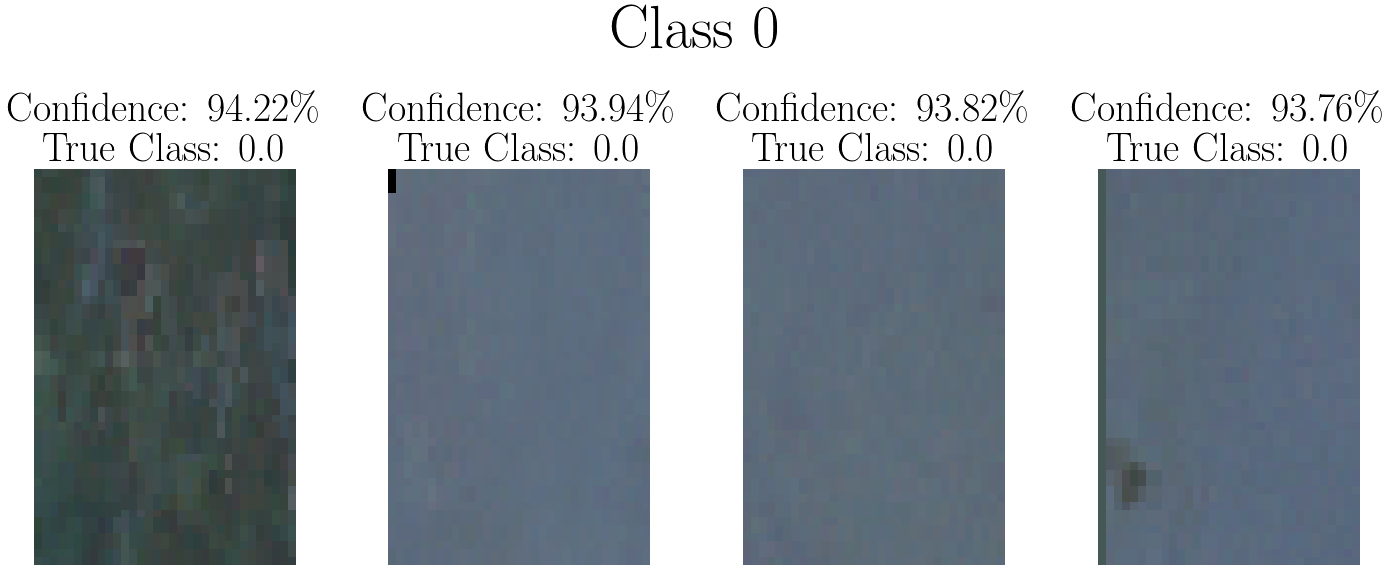

In [ ]:
plot_top_4_images(0)

In [ ]:
plot_top_4_images(1)

Not enough images


<Figure size 1440x720 with 0 Axes>

In [ ]:
plot_top_4_images(2)

Not enough images


<Figure size 1440x720 with 0 Axes>

In [ ]:
plot_top_4_images(3)

Not enough images


<Figure size 1440x720 with 0 Axes>

In [ ]:
plot_top_4_images(4)

Not enough images


<Figure size 1440x720 with 0 Axes>

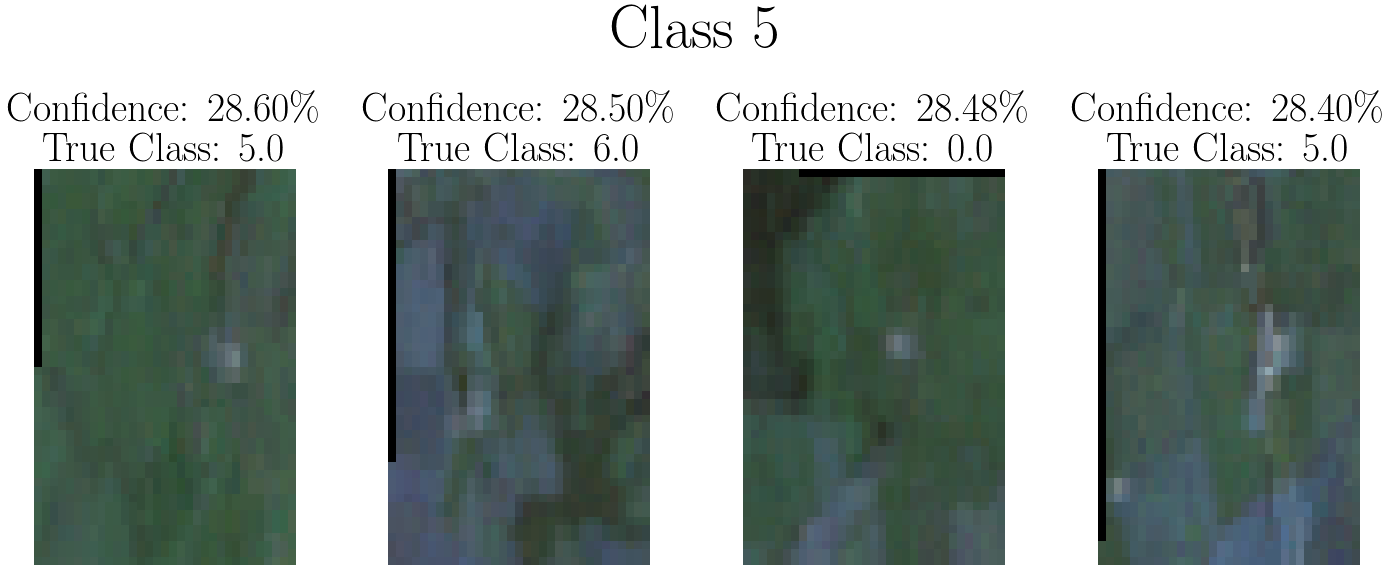

In [ ]:
plot_top_4_images(5)

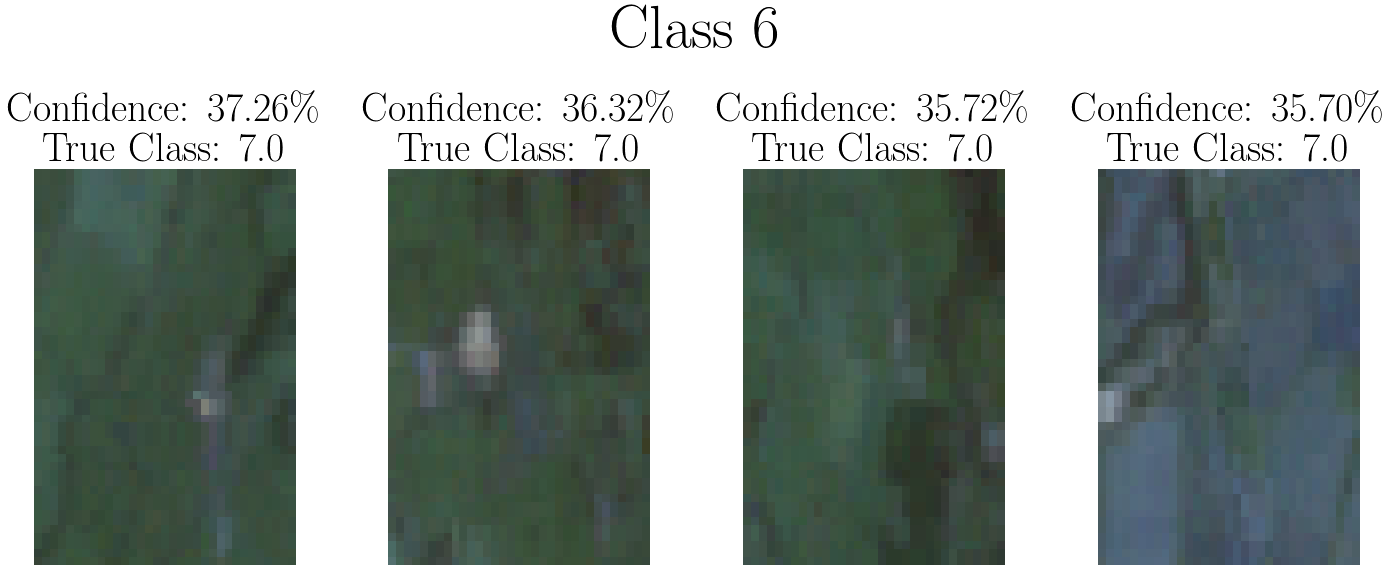

In [ ]:
plot_top_4_images(6)

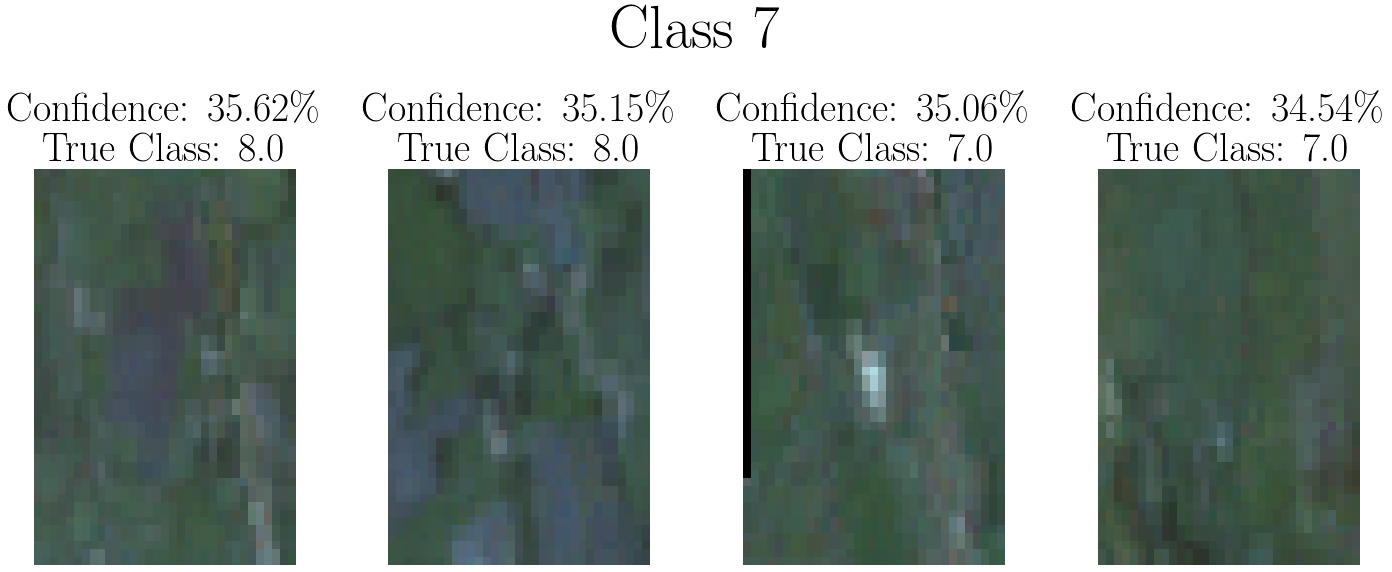

In [ ]:
plot_top_4_images(7)

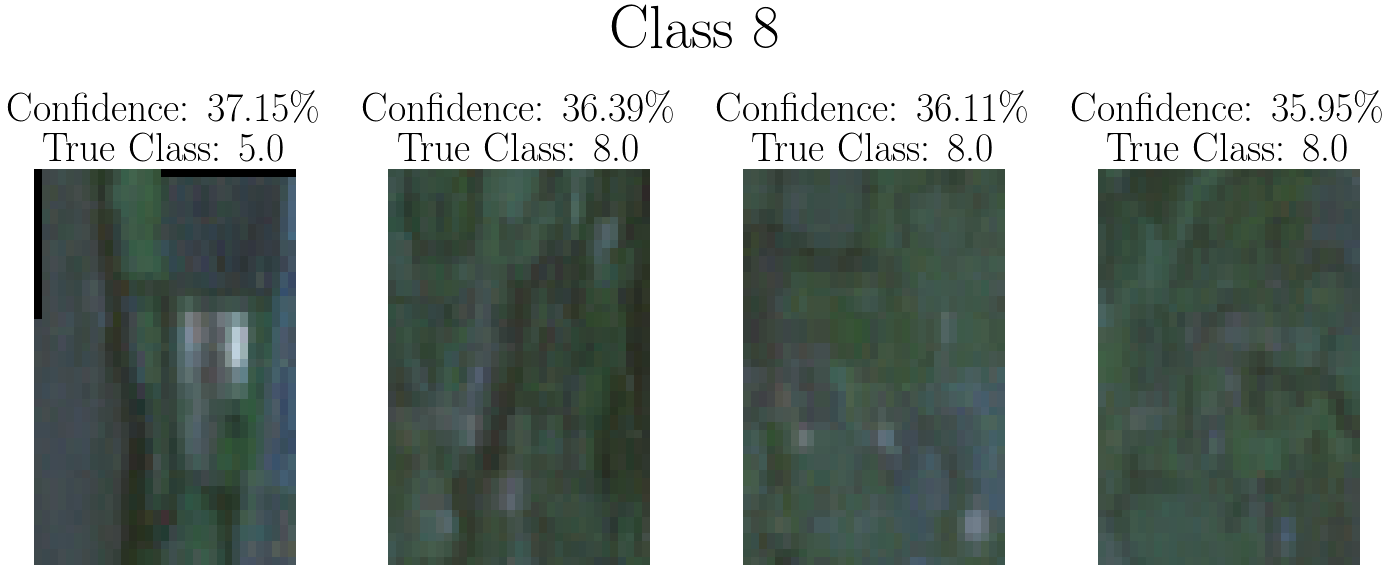

In [ ]:
plot_top_4_images(8)

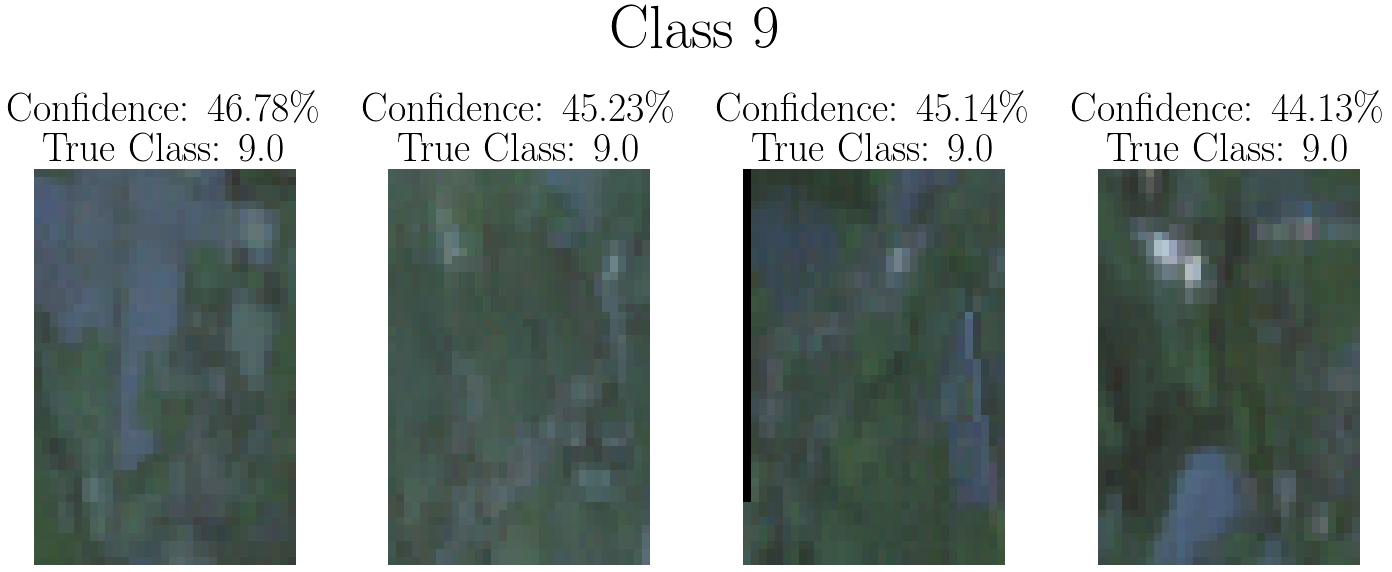

In [ ]:
plot_top_4_images(9)

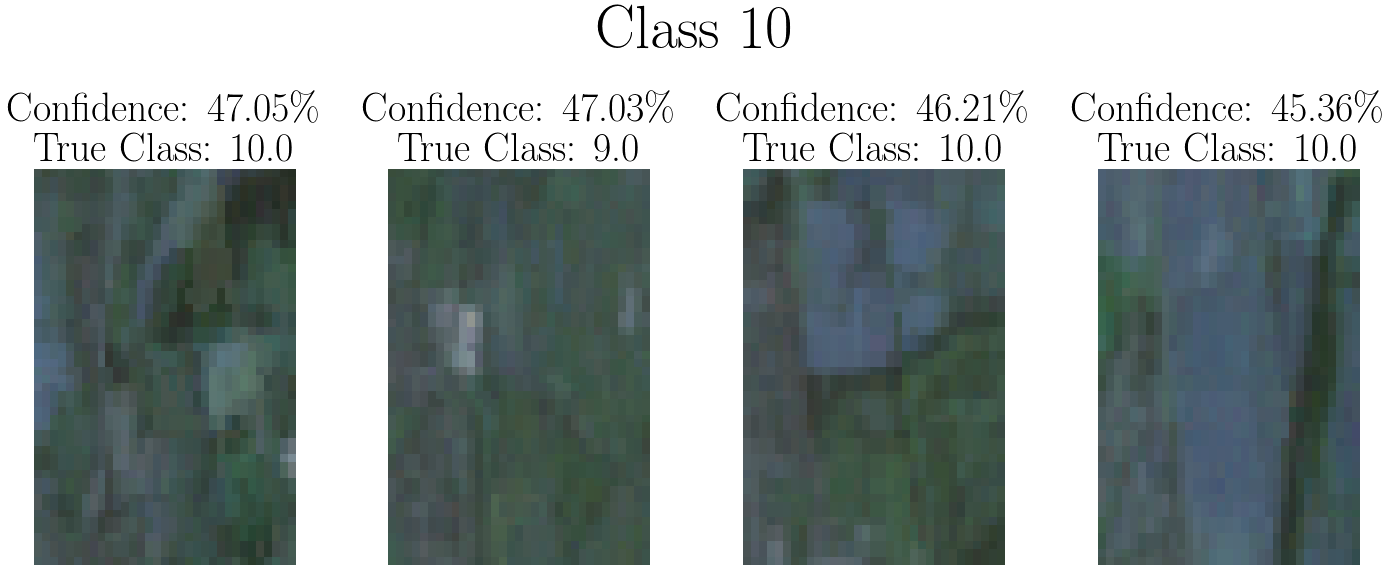

In [ ]:
plot_top_4_images(10)

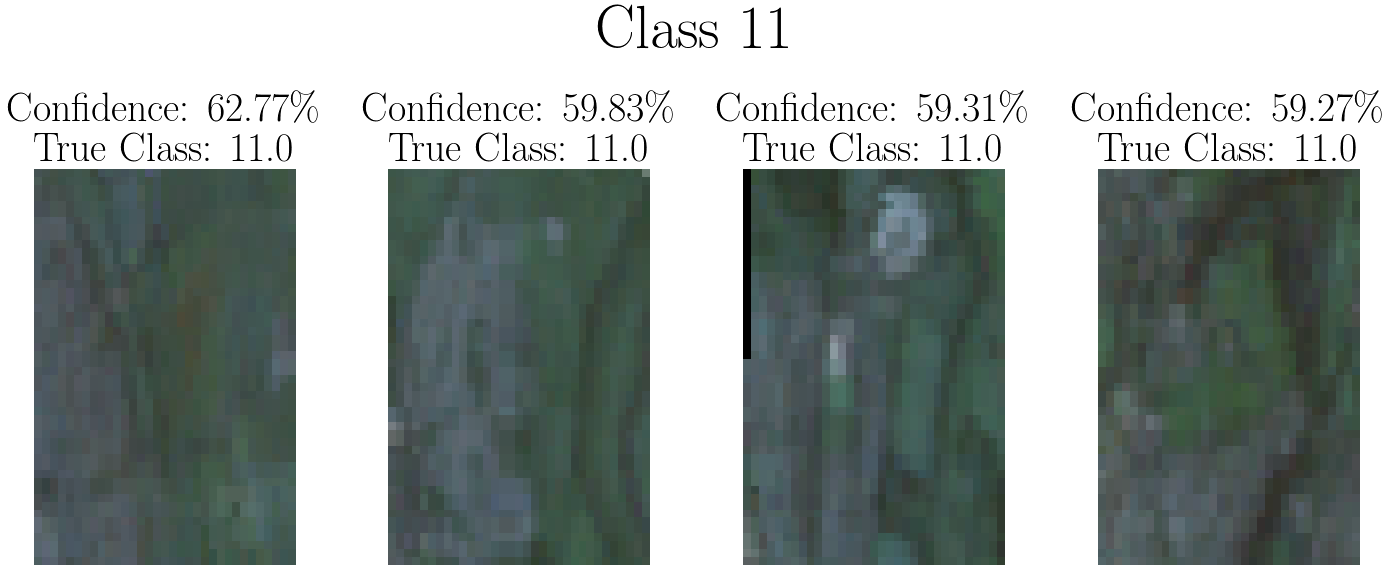

In [ ]:
plot_top_4_images(11)

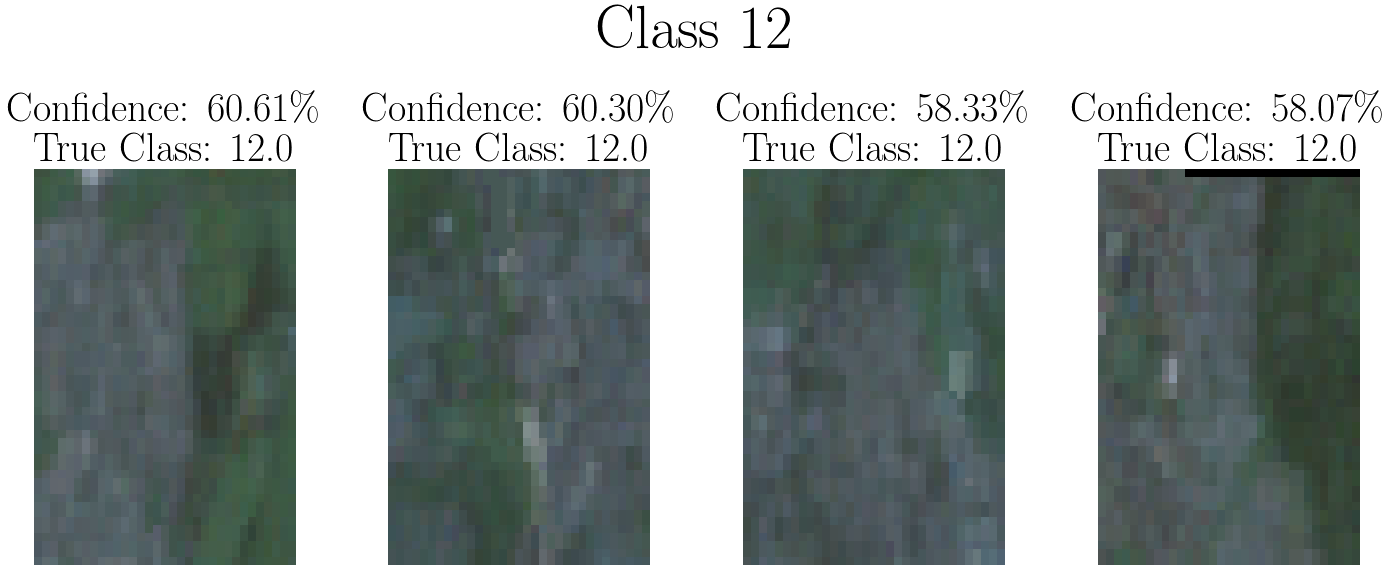

In [ ]:
plot_top_4_images(12)

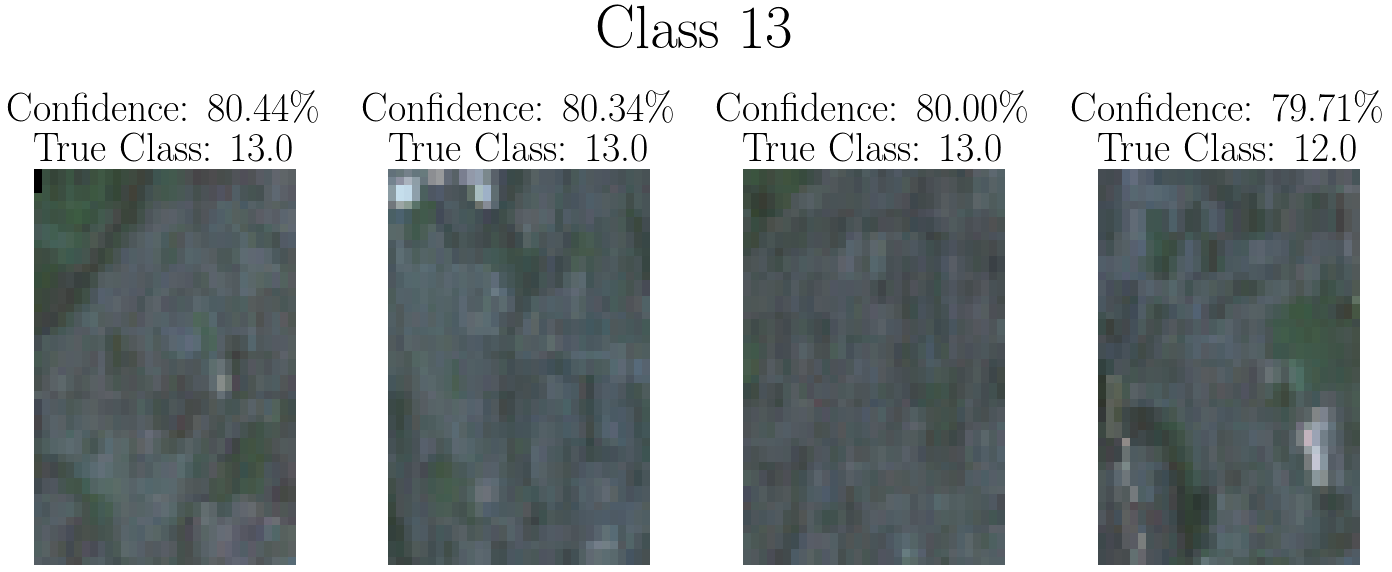

In [ ]:
plot_top_4_images(13)

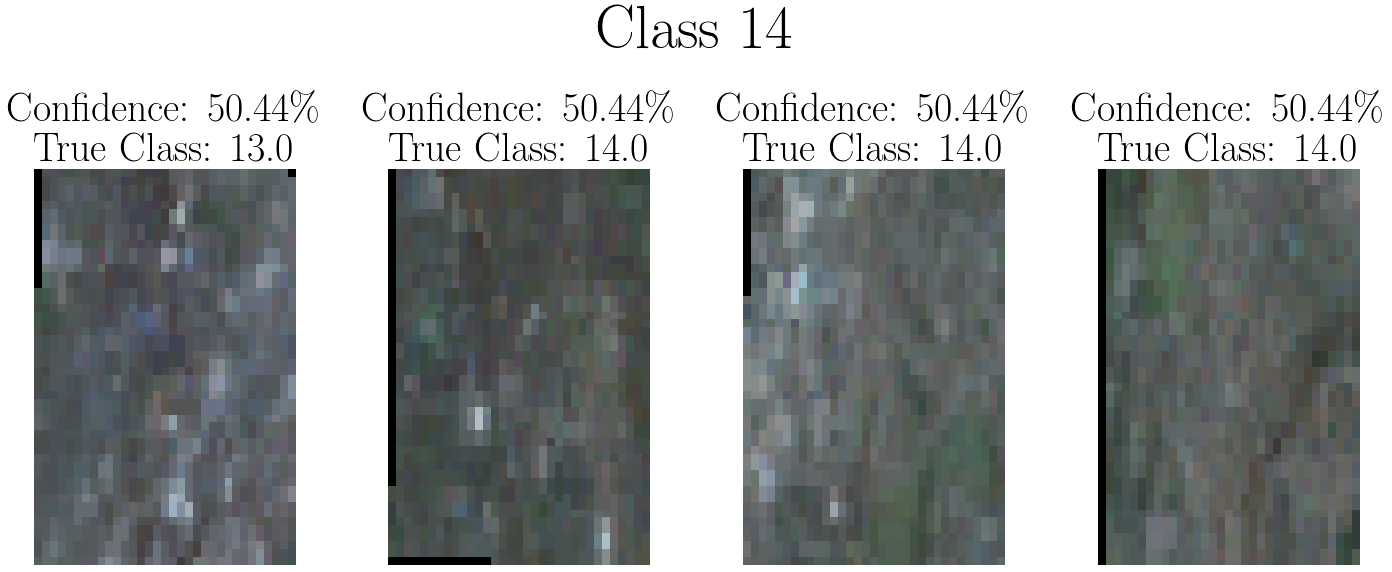

In [ ]:
plot_top_4_images(14)

In [ ]:
plot_top_4_images(15)

Not enough images


<Figure size 1440x720 with 0 Axes>

## First convolutional weights for 

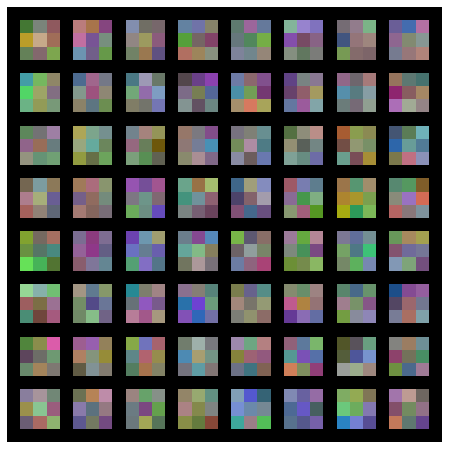

In [ ]:
# function to visualise weights from first conv layer
from torchvision import utils
conv1_weights = model_cl.convs[0].weight.data
num_filters = conv1_weights.shape[0]

fig = plt.figure(figsize=(8,8))
columns = 8
rows = num_filters / columns

grid =  utils.make_grid(conv1_weights, nrow=8, normalize=True, padding=1)
grid = grid.cpu()
plt.imshow(grid.numpy().transpose((1,2,0))[:,:,0:3])
plt.axis('off')
plt.ioff()
plt.show()

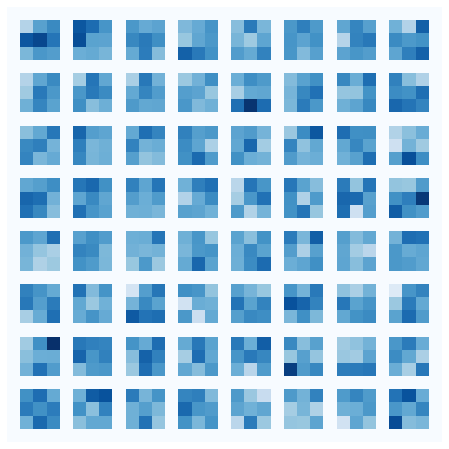

In [ ]:
fig = plt.figure(figsize=(8,8))
columns = 8
rows = num_filters / columns

grid =  utils.make_grid(conv1_weights, nrow=8, normalize=True, padding=1)
grid = grid.cpu()
plt.imshow(grid.numpy().transpose((1,2,0))[:,:,0], "Blues")
plt.axis('off')
plt.ioff()
plt.show()

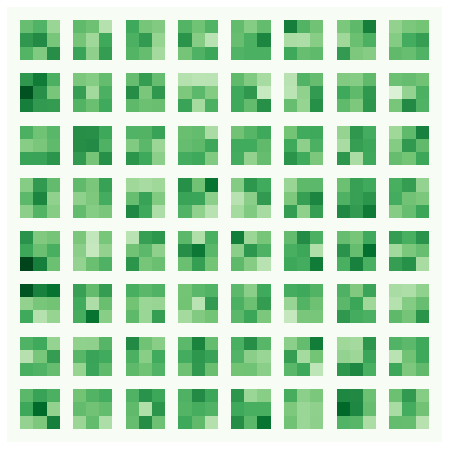

In [ ]:
fig = plt.figure(figsize=(8,8))
columns = 8
rows = num_filters / columns

grid =  utils.make_grid(conv1_weights, nrow=8, normalize=True, padding=1)
grid = grid.cpu()
plt.imshow(grid.numpy().transpose((1,2,0))[:,:,1], "Greens")
plt.axis('off')
plt.ioff()
plt.show()

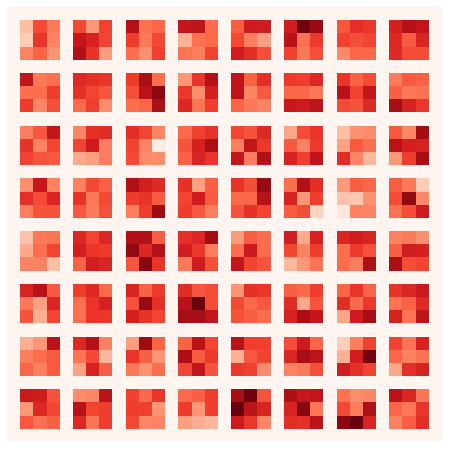

In [ ]:
fig = plt.figure(figsize=(8,8))
columns = 8
rows = num_filters / columns

grid =  utils.make_grid(conv1_weights, nrow=8, normalize=True, padding=1)
grid = grid.cpu()
plt.imshow(grid.numpy().transpose((1,2,0))[:,:,2], "Reds")
plt.axis('off')
plt.ioff()
plt.show()

# Activations

In [ ]:
# Selected images to pass through network and visualise activations
image_for_activ, label_for_activ = class_images['Class 13'][0][0], class_images['Class 14'][0][3]
image_for_activ2, label_for_activ2 = class_images['Class 0'][0][0], class_images['Class 0'][0][3]
image_for_activ3, label_for_activ3 = class_images['Class 8'][3][0], class_images['Class 8'][3][3]

In [ ]:
# Set fonts for plots
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Captured forward hooks for image.
Layer 0: Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 1: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 2: ReLU(inplace=True)
Layer 3: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 4: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 5: ReLU(inplace=True)
Layer 6: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 7: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 8: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 9: ReLU(inplace=True)
Layer 10: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 11: BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 12: ReLU(inplace=True)
Layer 13: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 14: Conv2d(128, 

/content/Sat_Image_Dataset/Visualisation.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))


Layer 28: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 29: ReLU(inplace=True)
Layer 30: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 31: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 32: ReLU(inplace=True)
Layer 33: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 34: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 35: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 36: ReLU(inplace=True)
Layer 37: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 38: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 39: ReLU(inplace=True)
Layer 40: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Layer 41: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer 42: ReLU(inplace=True)
Lay

RuntimeError: ignored

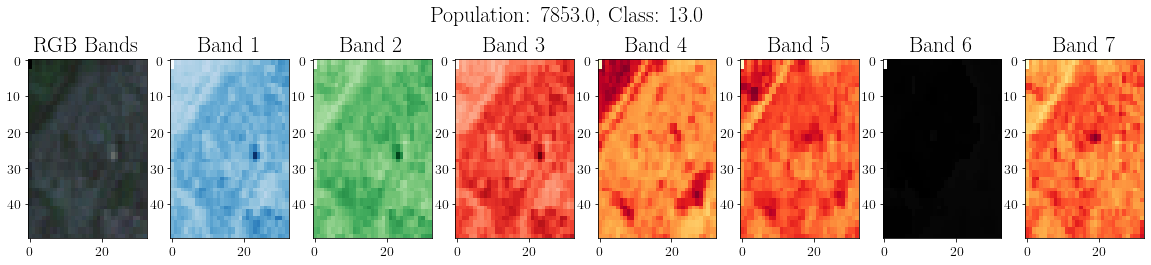

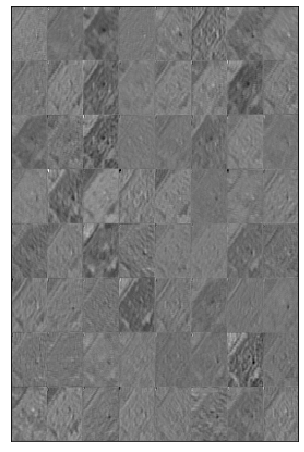

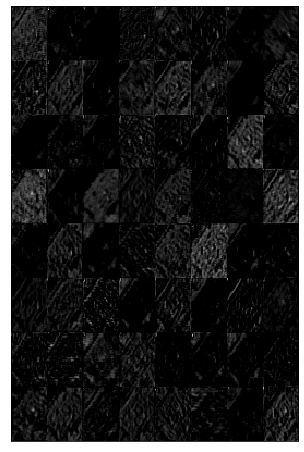

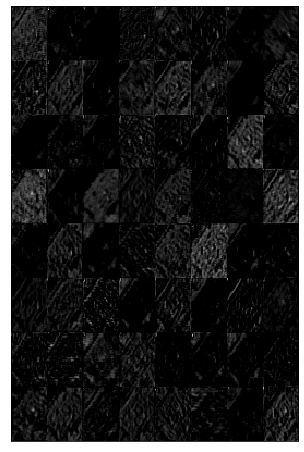

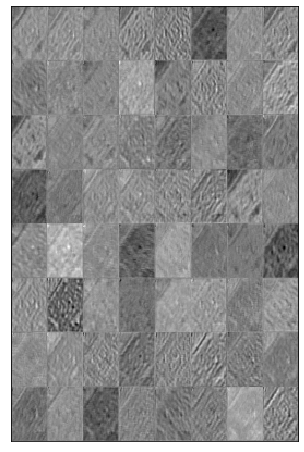

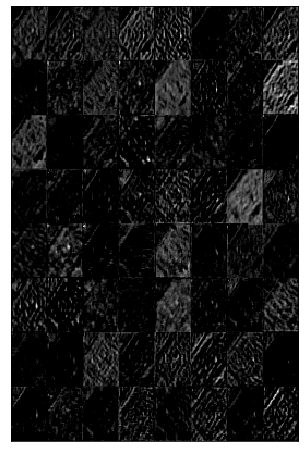

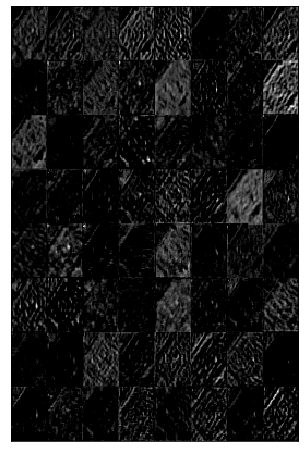

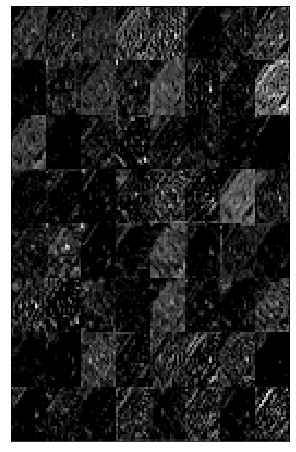

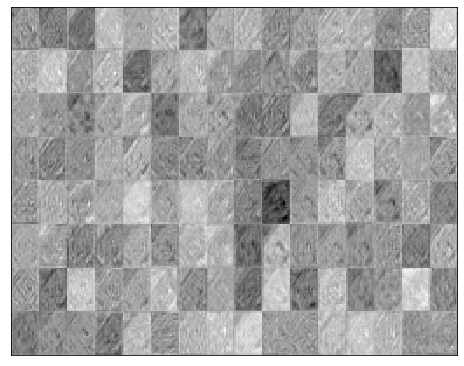

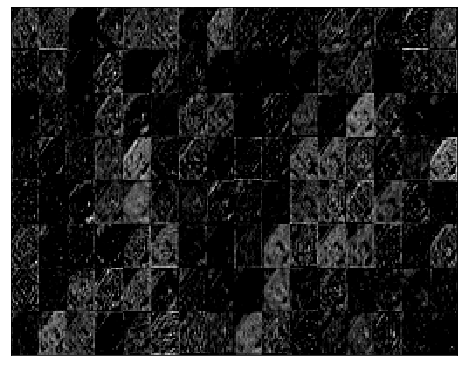

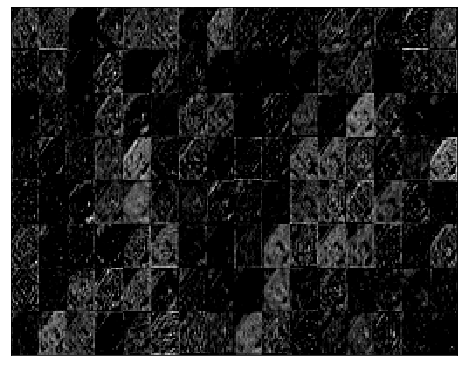

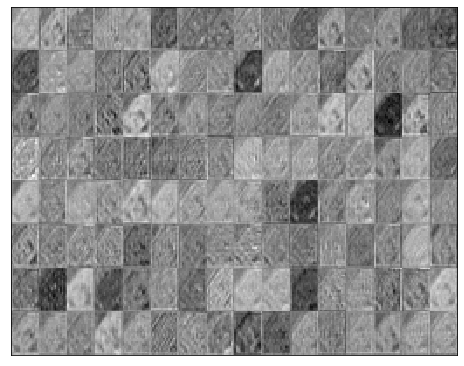

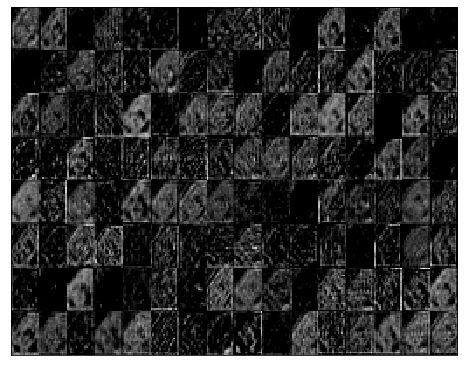

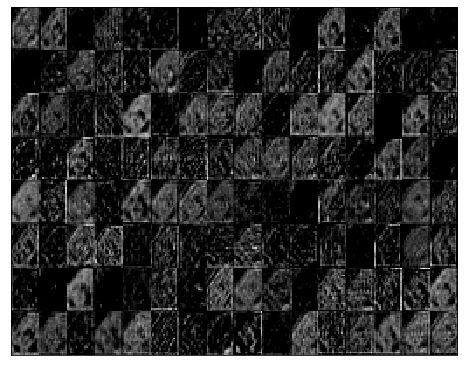

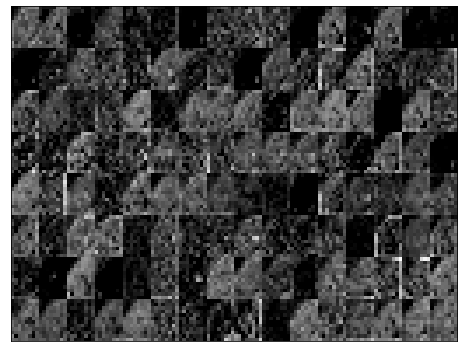

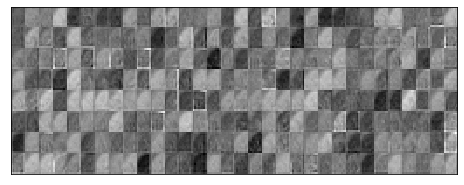

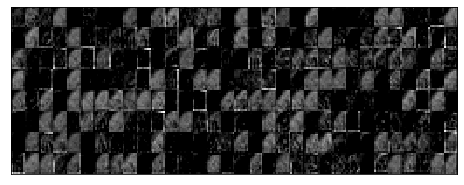

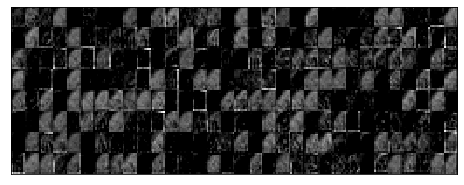

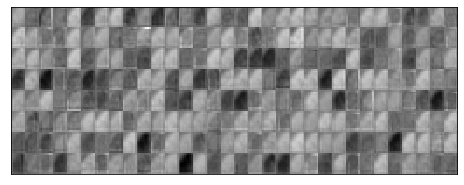

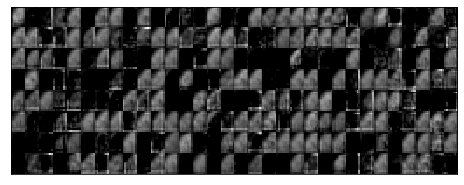

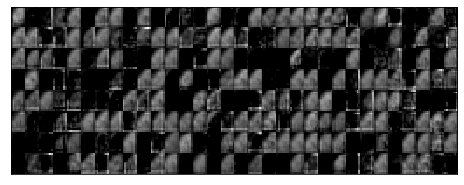

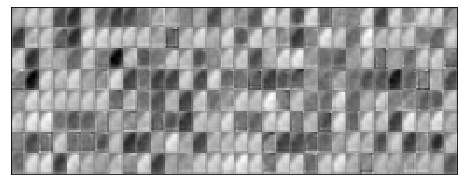

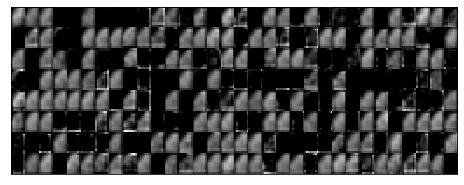

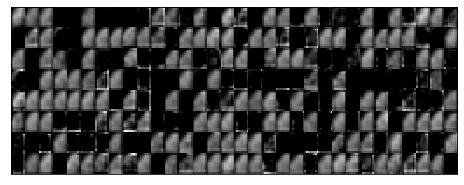

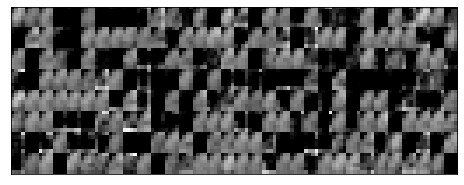

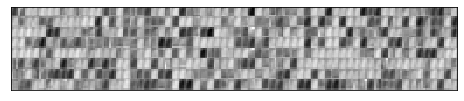

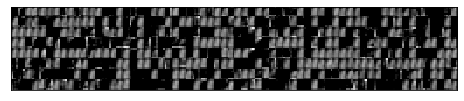

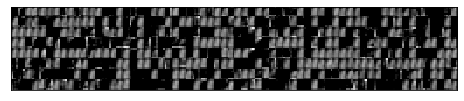

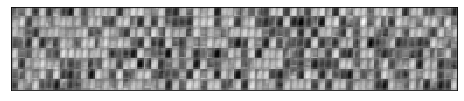

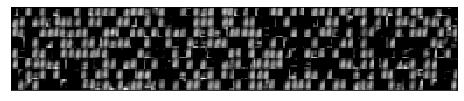

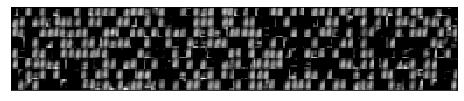

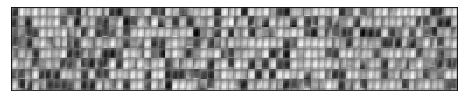

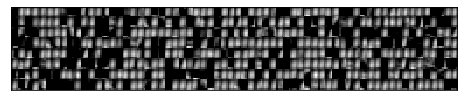

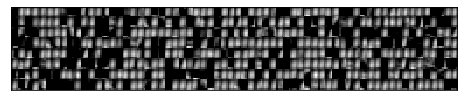

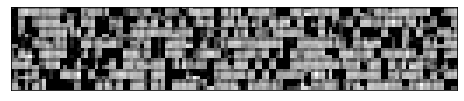

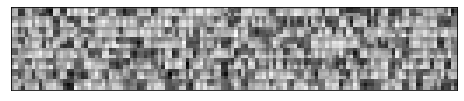

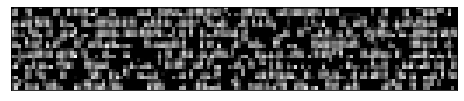

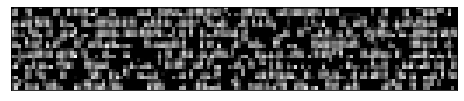

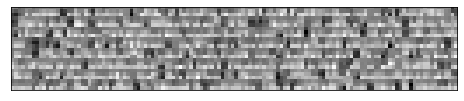

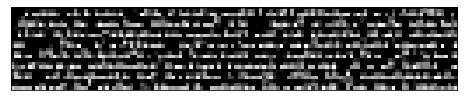

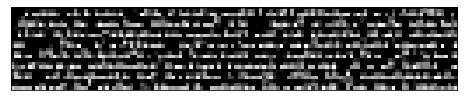

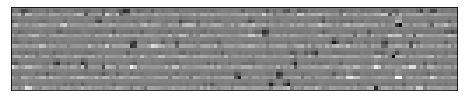

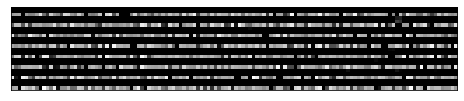

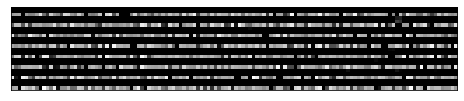

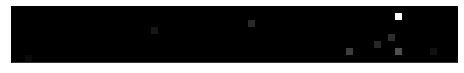

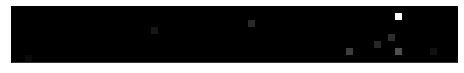

In [ ]:
display_layer_activations(model_cl, (image_for_activ, label_for_activ), device, sat_mean, sat_std)

In [ ]:
display_layer_activations(model_cl, (image_for_activ2, label_for_activ2), device, sat_mean, sat_std)

In [ ]:
display_layer_activations(model_cl, (image_for_activ3, label_for_activ3), device, sat_mean, sat_std)

# Histograms

In [ ]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

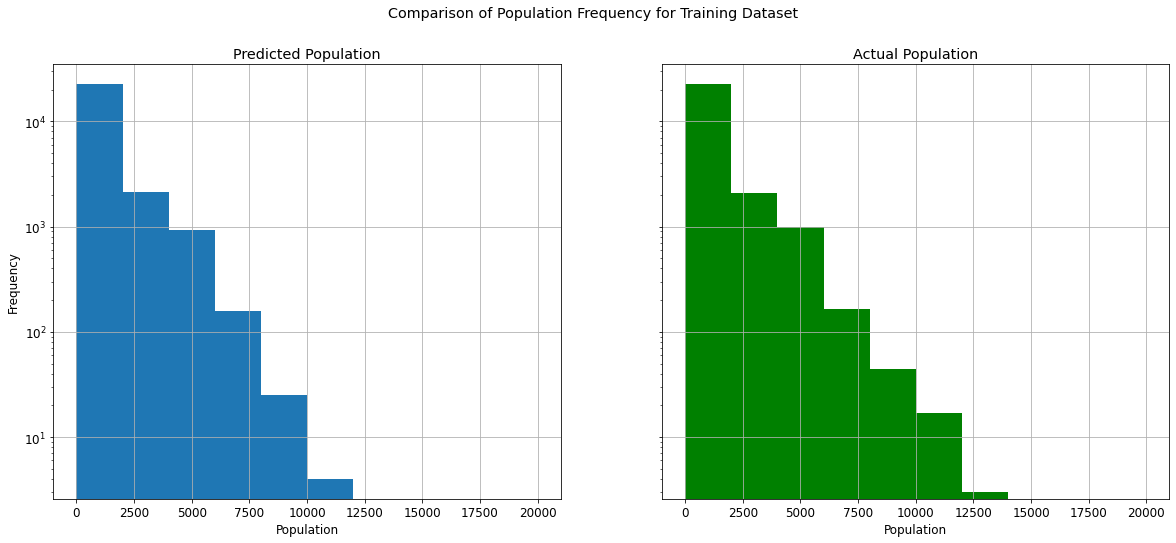

In [ ]:
# Visualise predictions vs actual for regression (train set)
preds = [item[1] for item in results_reg_train]
pop = [item[2] for item in results_reg_train]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(20, 8)
fig.suptitle("Comparison of Population Frequency for Training Dataset")
ax1.hist(preds, range=(0, 20000))
ax1.set_yscale("log")
ax1.grid(True)
ax1.set_title("Predicted Population")
ax1.set_xlabel("Population")
ax1.set_ylabel("Frequency")
ax2.hist(pop, range=(0, 20000), color="Green")
ax2.set_yscale("log")
ax2.grid(True)
ax2.set_xlabel("Population")
ax2.set_title("Actual Population")
plt.show()

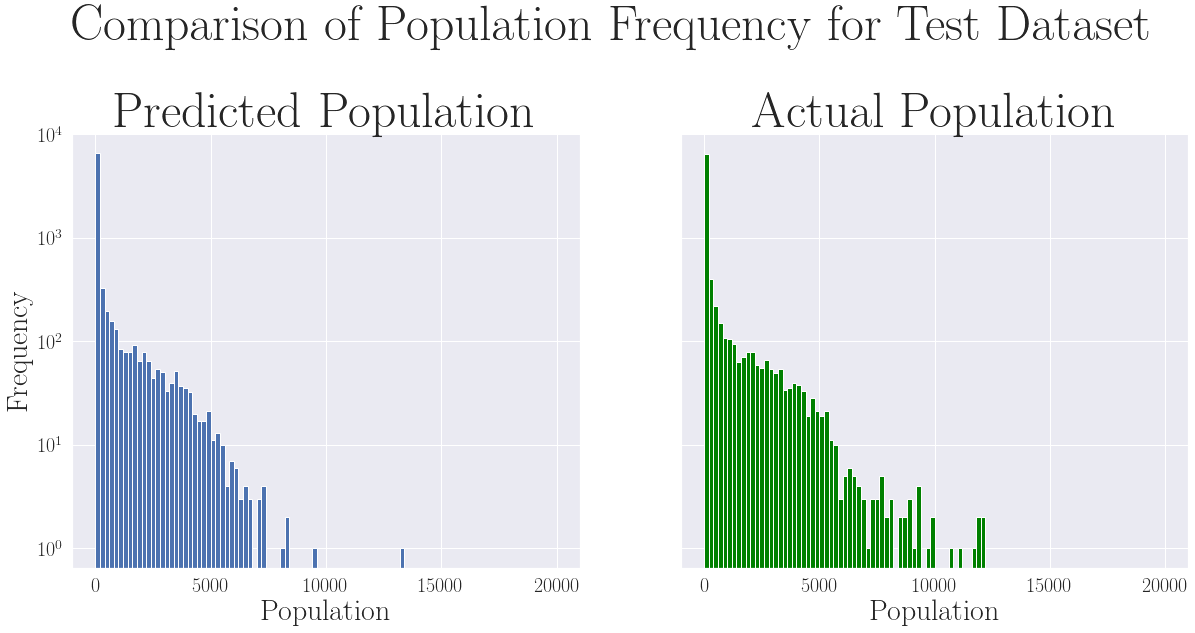

In [ ]:
# Visualise predictions vs actual for regression (test set)
preds = [item[1] for item in results_reg_test]
pop = [item[2] for item in results_reg_test]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(20, 8)
fig.suptitle("Comparison of Population Frequency for Test Dataset", y=1.1)
ax1.hist(preds, range=(0, 20000), bins=100)
ax1.grid(True)
ax1.set_title("Predicted Population")
ax1.set_xlabel("Population")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.hist(pop, range=(0, 20000), color="Green", bins=100)
ax2.set_yscale("log")
ax2.grid(True)
ax2.set_xlabel("Population")
ax2.set_title("Actual Population")
plt.savefig('Reg Pop Dist', dpi=300, pad_inches=0)
plt.show()

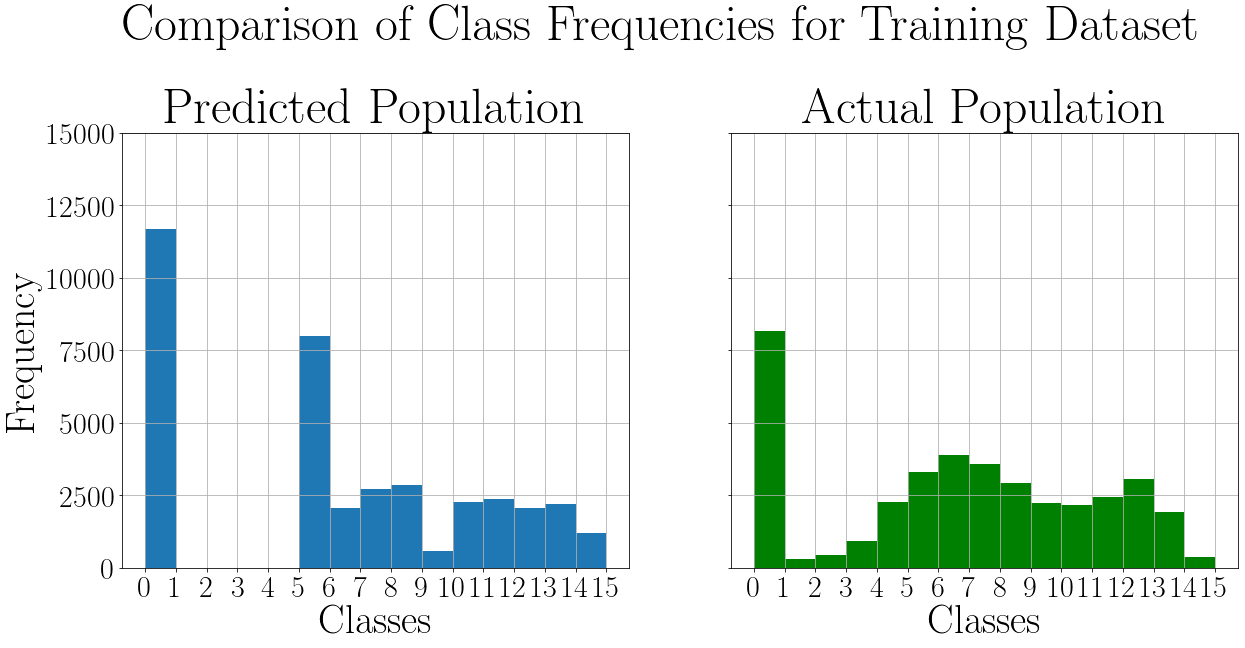

In [ ]:
# Visualise predictions vs actual for classification (train set)
preds = [item[1] for item in results_cl_train]
pop = [item[2] for item in results_cl_train]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(20, 8)
fig.suptitle("Comparison of Class Frequencies for Training Dataset", y=1.1)
plt.ylim(0, 15000)
ax1.hist(preds, bins=range(0, 16))
ax1.set_xticks(ticks=range(0, 16))
ax1.grid(True)
ax1.set_title("Predicted Population")
ax1.set_xlabel("Classes")
ax1.set_ylabel("Frequency")
ax2.hist(pop, bins=range(0, 16), color="Green")
ax2.grid(True)
ax2.set_xticks(ticks=range(0, 16))
ax2.set_xlabel("Classes")
ax2.set_title("Actual Population")
plt.show()

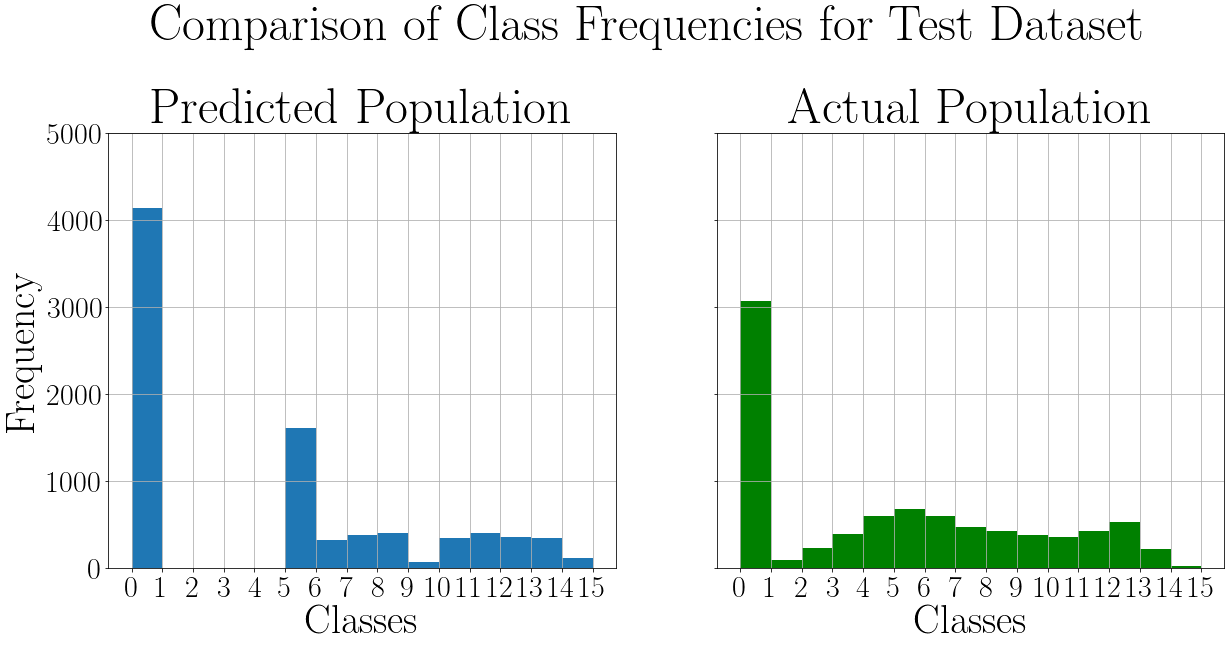

In [ ]:
# Visualise predictions vs actual for classification (test set)
preds = [item[1] for item in results_cl_test]
pop = [item[2] for item in results_cl_test]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(20, 8)
fig.suptitle("Comparison of Class Frequencies for Test Dataset", y=1.1)
plt.ylim(0, 5000)
ax1.hist(preds, bins=range(0, 16))
ax1.grid(True)
ax1.set_xticks(ticks=range(0, 16))
ax1.set_title("Predicted Population")
ax1.set_xlabel("Classes")
ax1.set_ylabel("Frequency")
ax2.hist(pop, bins=range(0, 16), color="Green")
ax2.grid(True)
ax2.set_xticks(ticks=range(0, 16))
ax2.set_xlabel("Classes")
ax2.set_title("Actual Population")
plt.savefig('Cla Pop Dist', dpi=300, pad_inches=0)
plt.show()

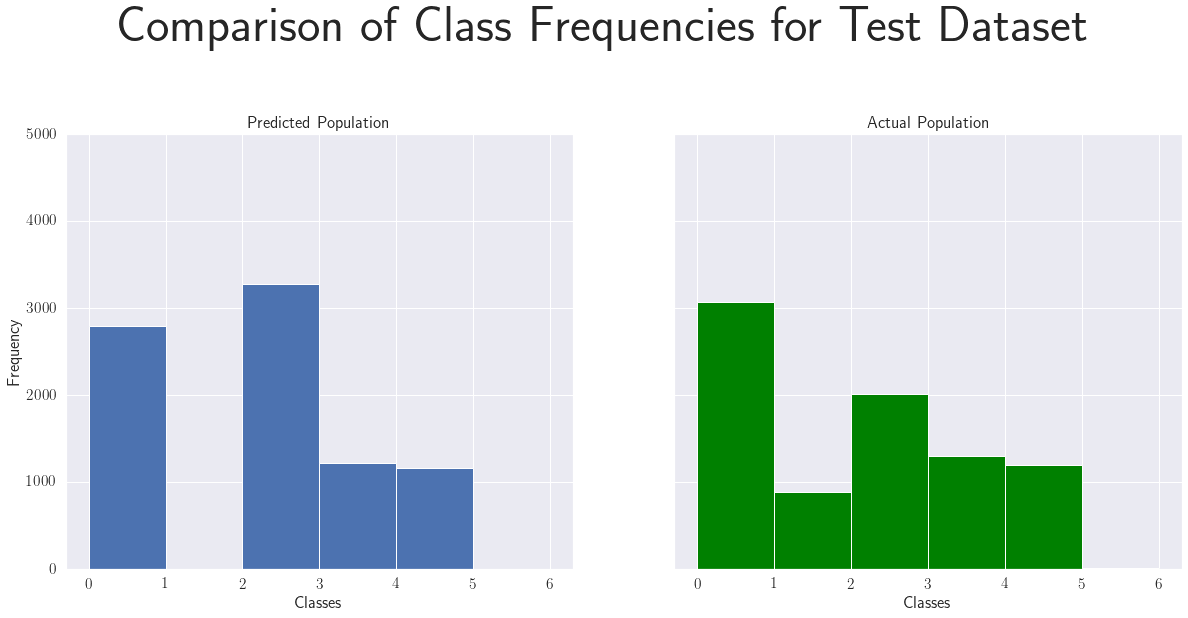

In [ ]:
# Visualise predictions vs actual for classification 6 classes (test set)
preds = [item[1] for item in results_cl6_test]
pop = [item[2] for item in results_cl6_test]

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(20, 8)
fig.suptitle("Comparison of Class Frequencies for Test Dataset", y=1.1)
plt.ylim(0, 5000)
ax1.hist(preds, bins=range(0, 7))
ax1.grid(True)
ax1.set_xticks(ticks=range(0, 7))
ax1.set_title("Predicted Population")
ax1.set_xlabel("Classes")
ax1.set_ylabel("Frequency")
ax2.hist(pop, bins=range(0, 7), color="Green")
ax2.grid(True)
ax2.set_xticks(ticks=range(0, 7))
ax2.set_xlabel("Classes")
ax2.set_title("Actual Population")
plt.savefig('Cla Pop Dist', dpi=300, pad_inches=0)
plt.show()

# Confusion Matrices

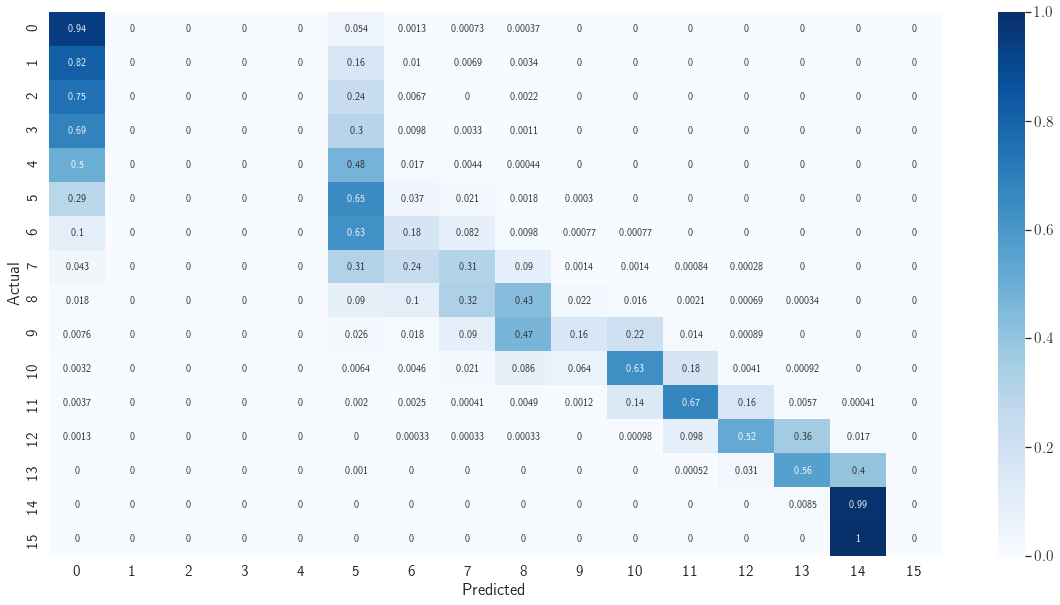

In [ ]:
confusion_matrix(results_cl_train)

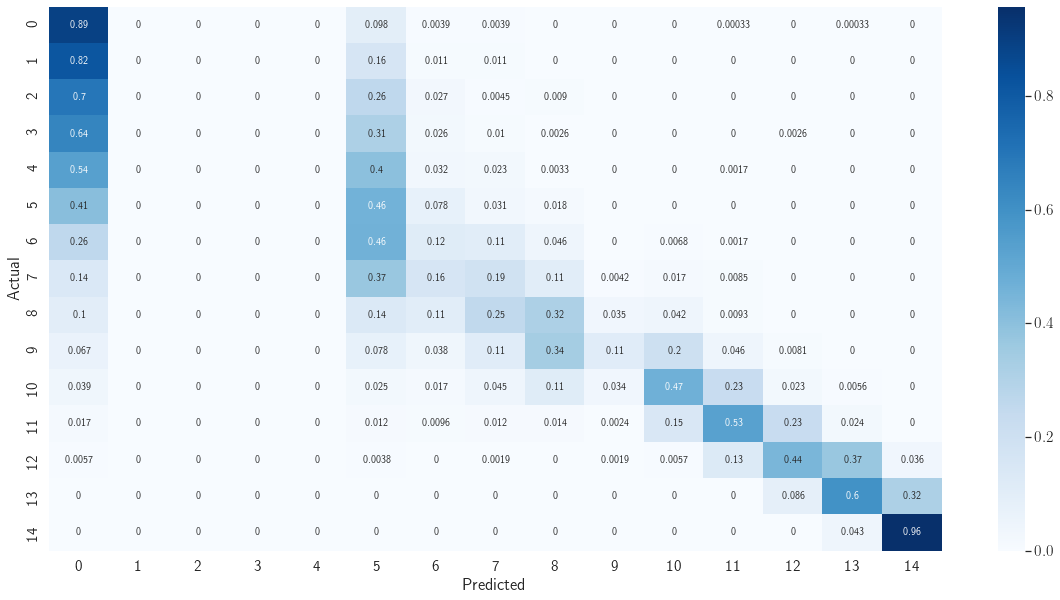

In [ ]:
confusion_matrix(results_cl_test)

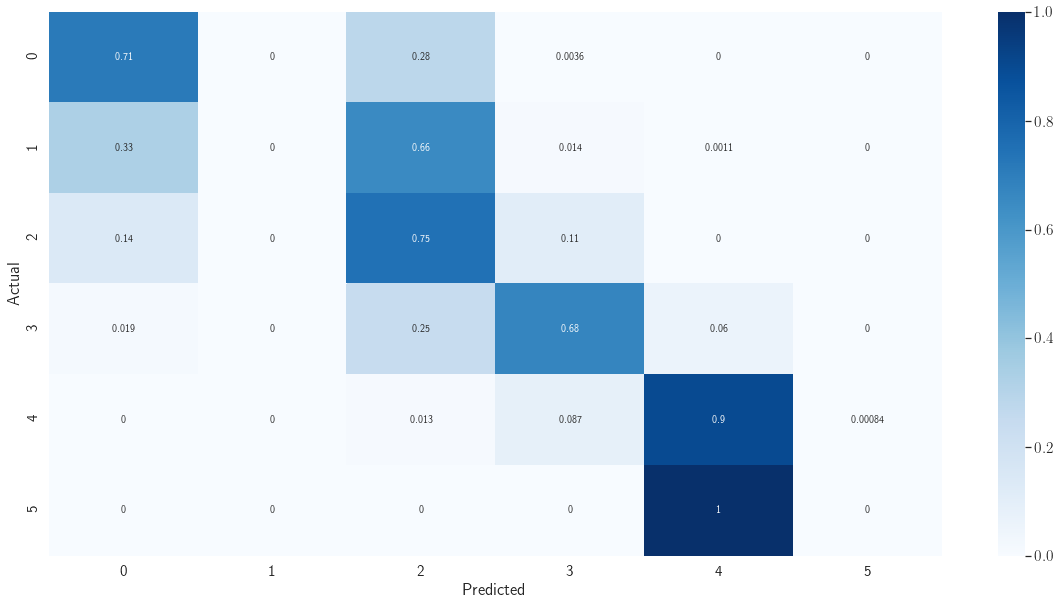

In [ ]:
confusion_matrix(results_cl6_test)

## Population Shapefile Plots

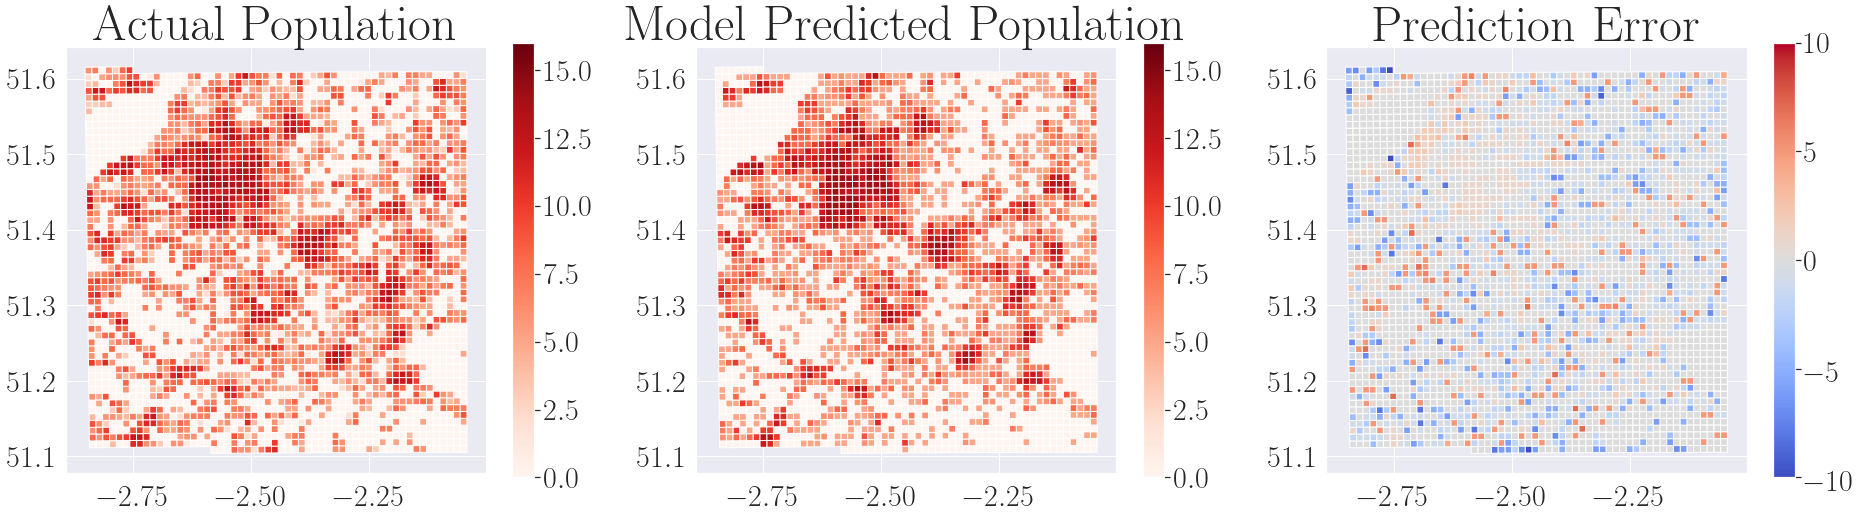

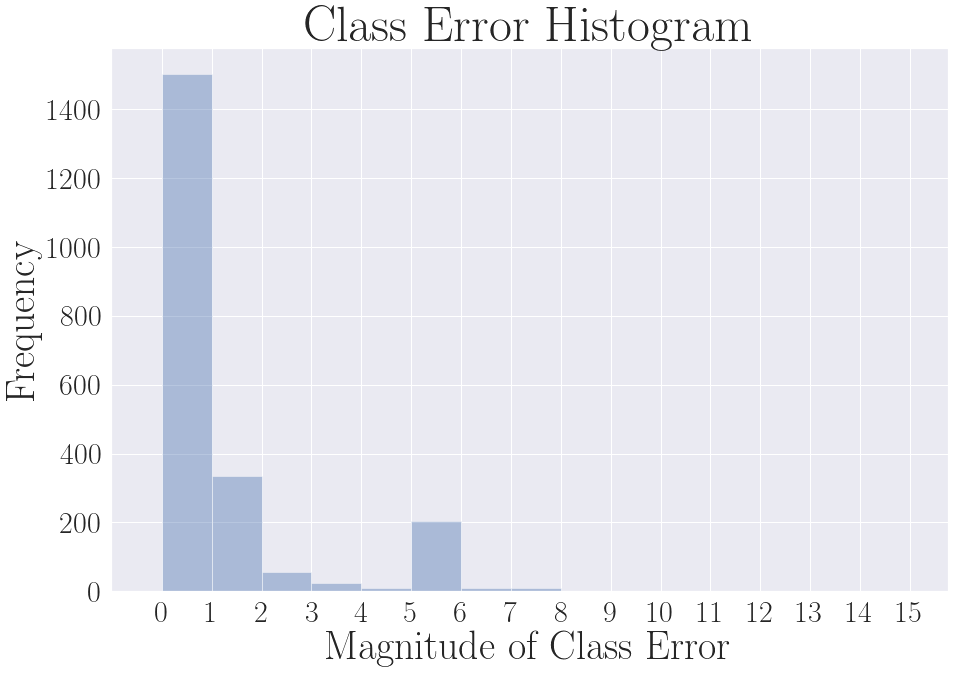

In [ ]:
# Test Region 1 - Model A
fonts(30, 40, 50)

shapefile_cl1 = shapefile_cl(results_cl_test, test_region=1)
shapefile_cl1.to_file("classification_testset1.shp")

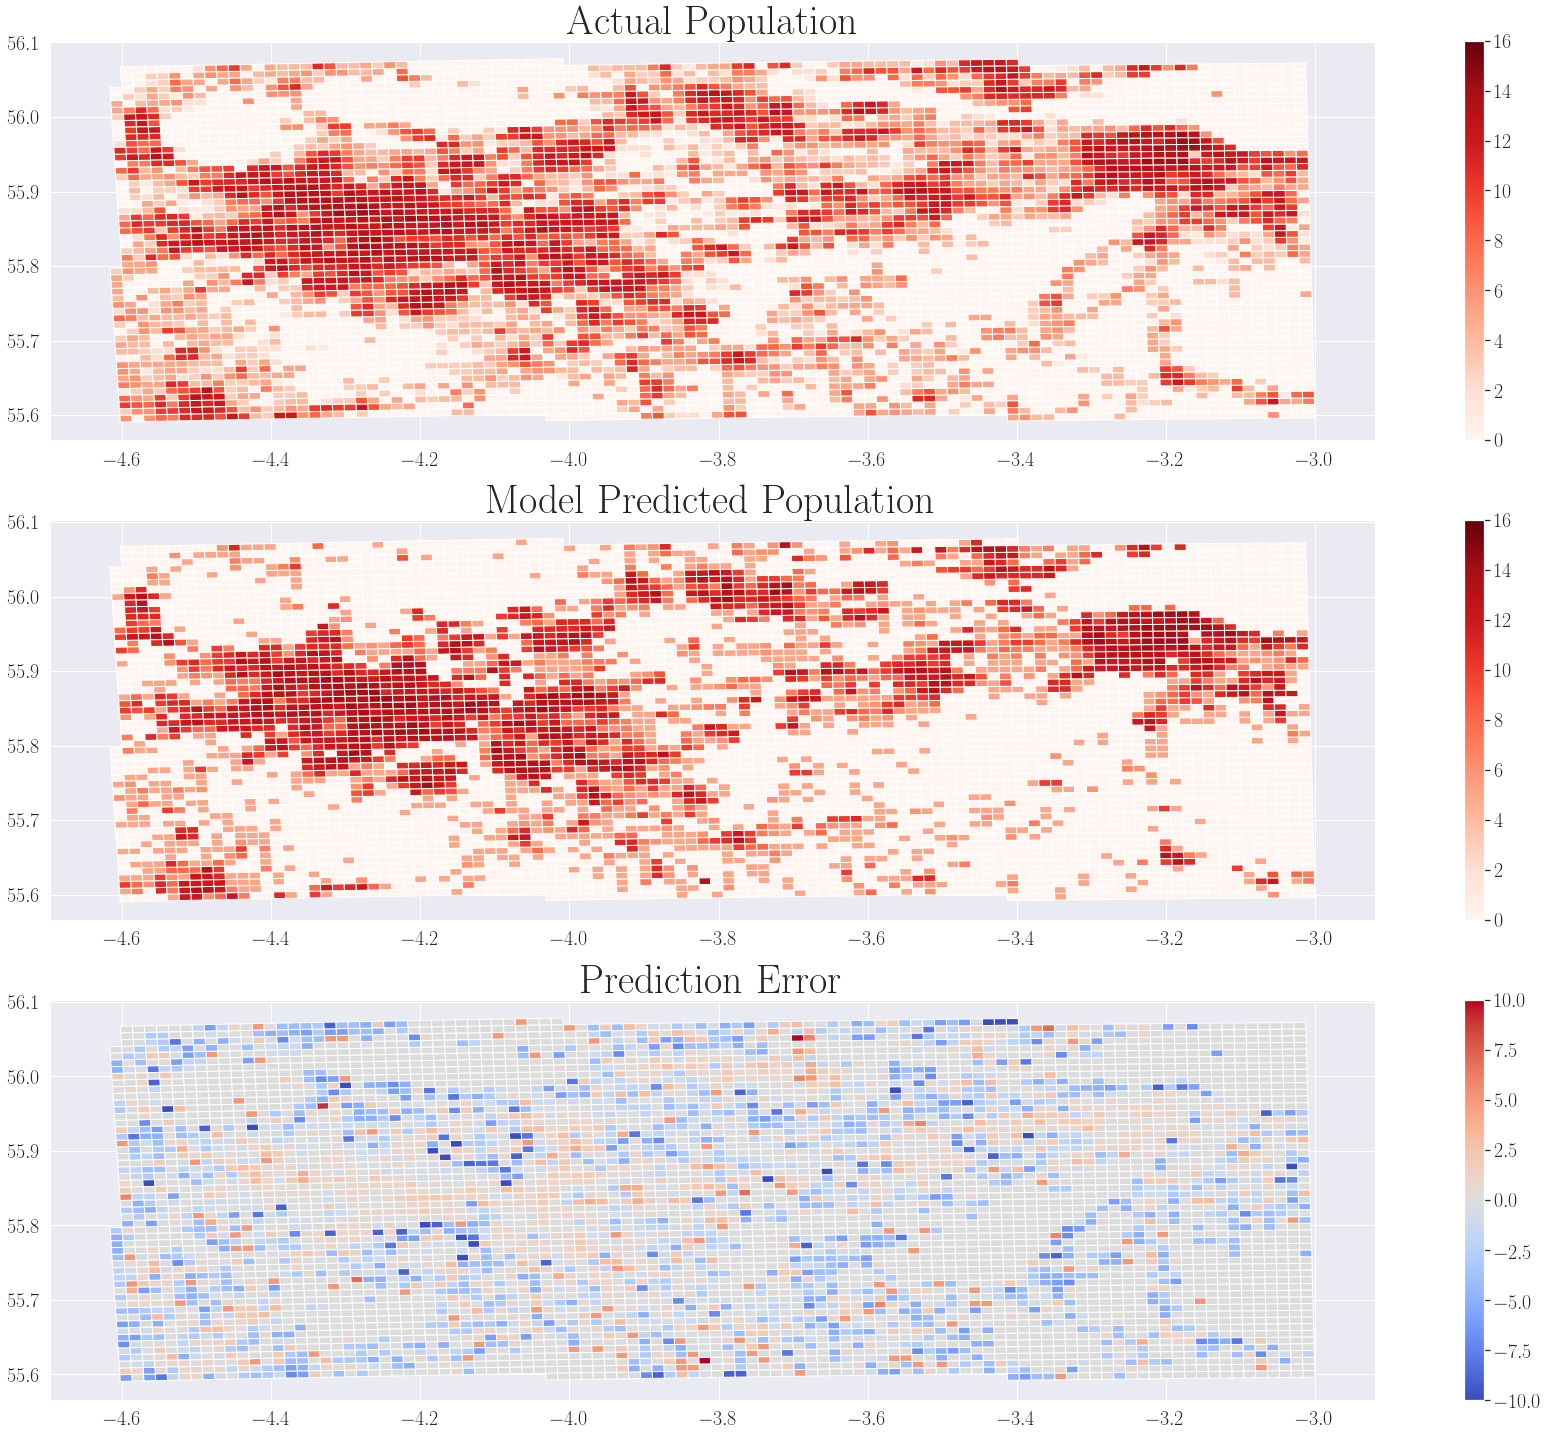

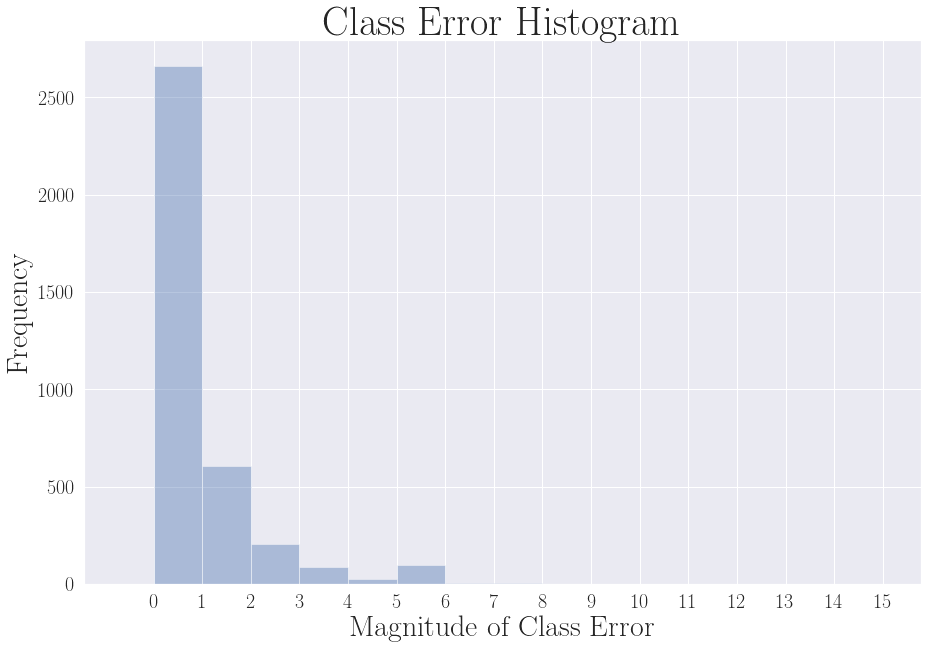

In [ ]:
# Test Region 2 - Model A
large_fonts()

shapefile_cl2 = shapefile_cl(results_cl_test, test_region=2)
shapefile_cl2.to_file("classification_testset2.shp")

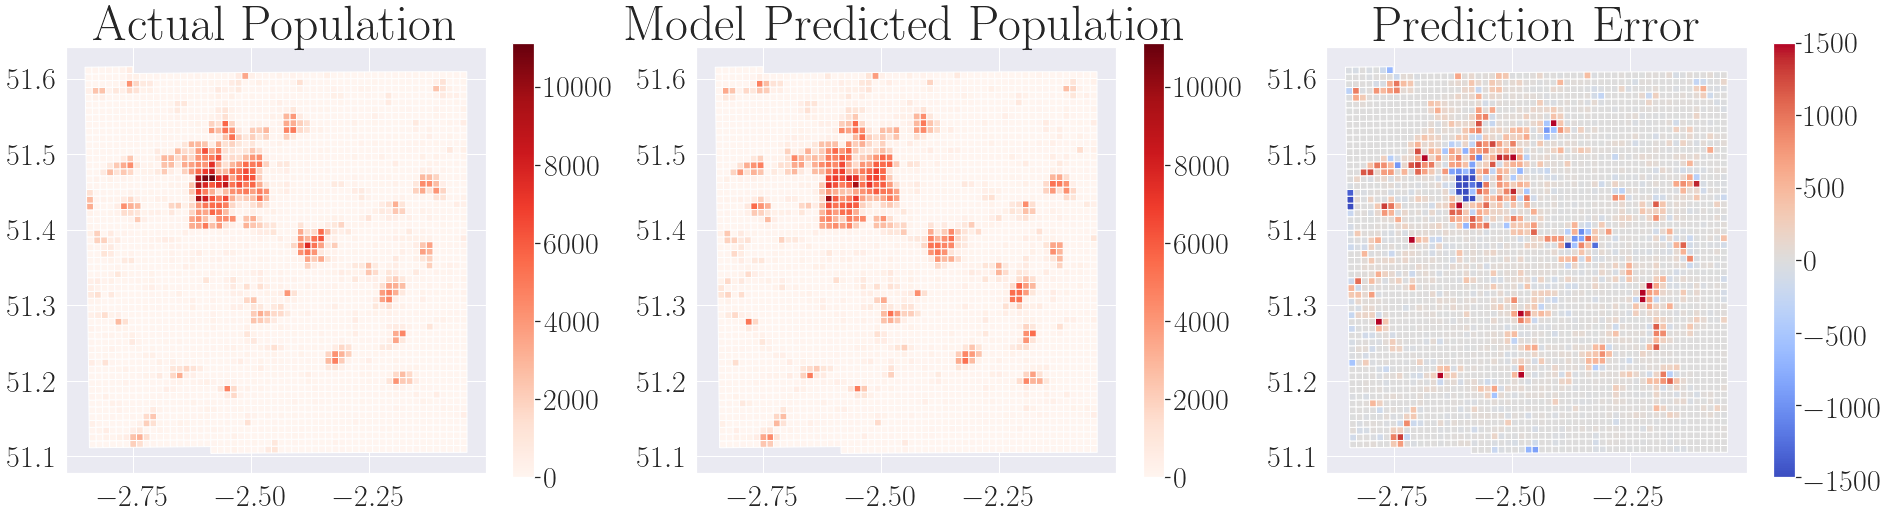

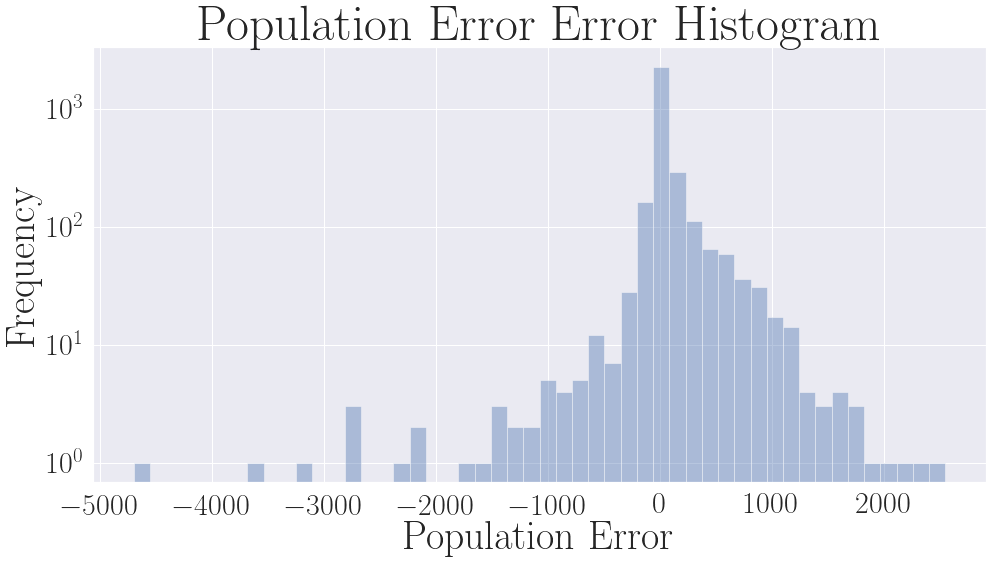

In [ ]:
# Test Region 1 - Model C
fonts(30, 40, 50)
shapefile_reg_result = shapefile_reg(results_reg_test)

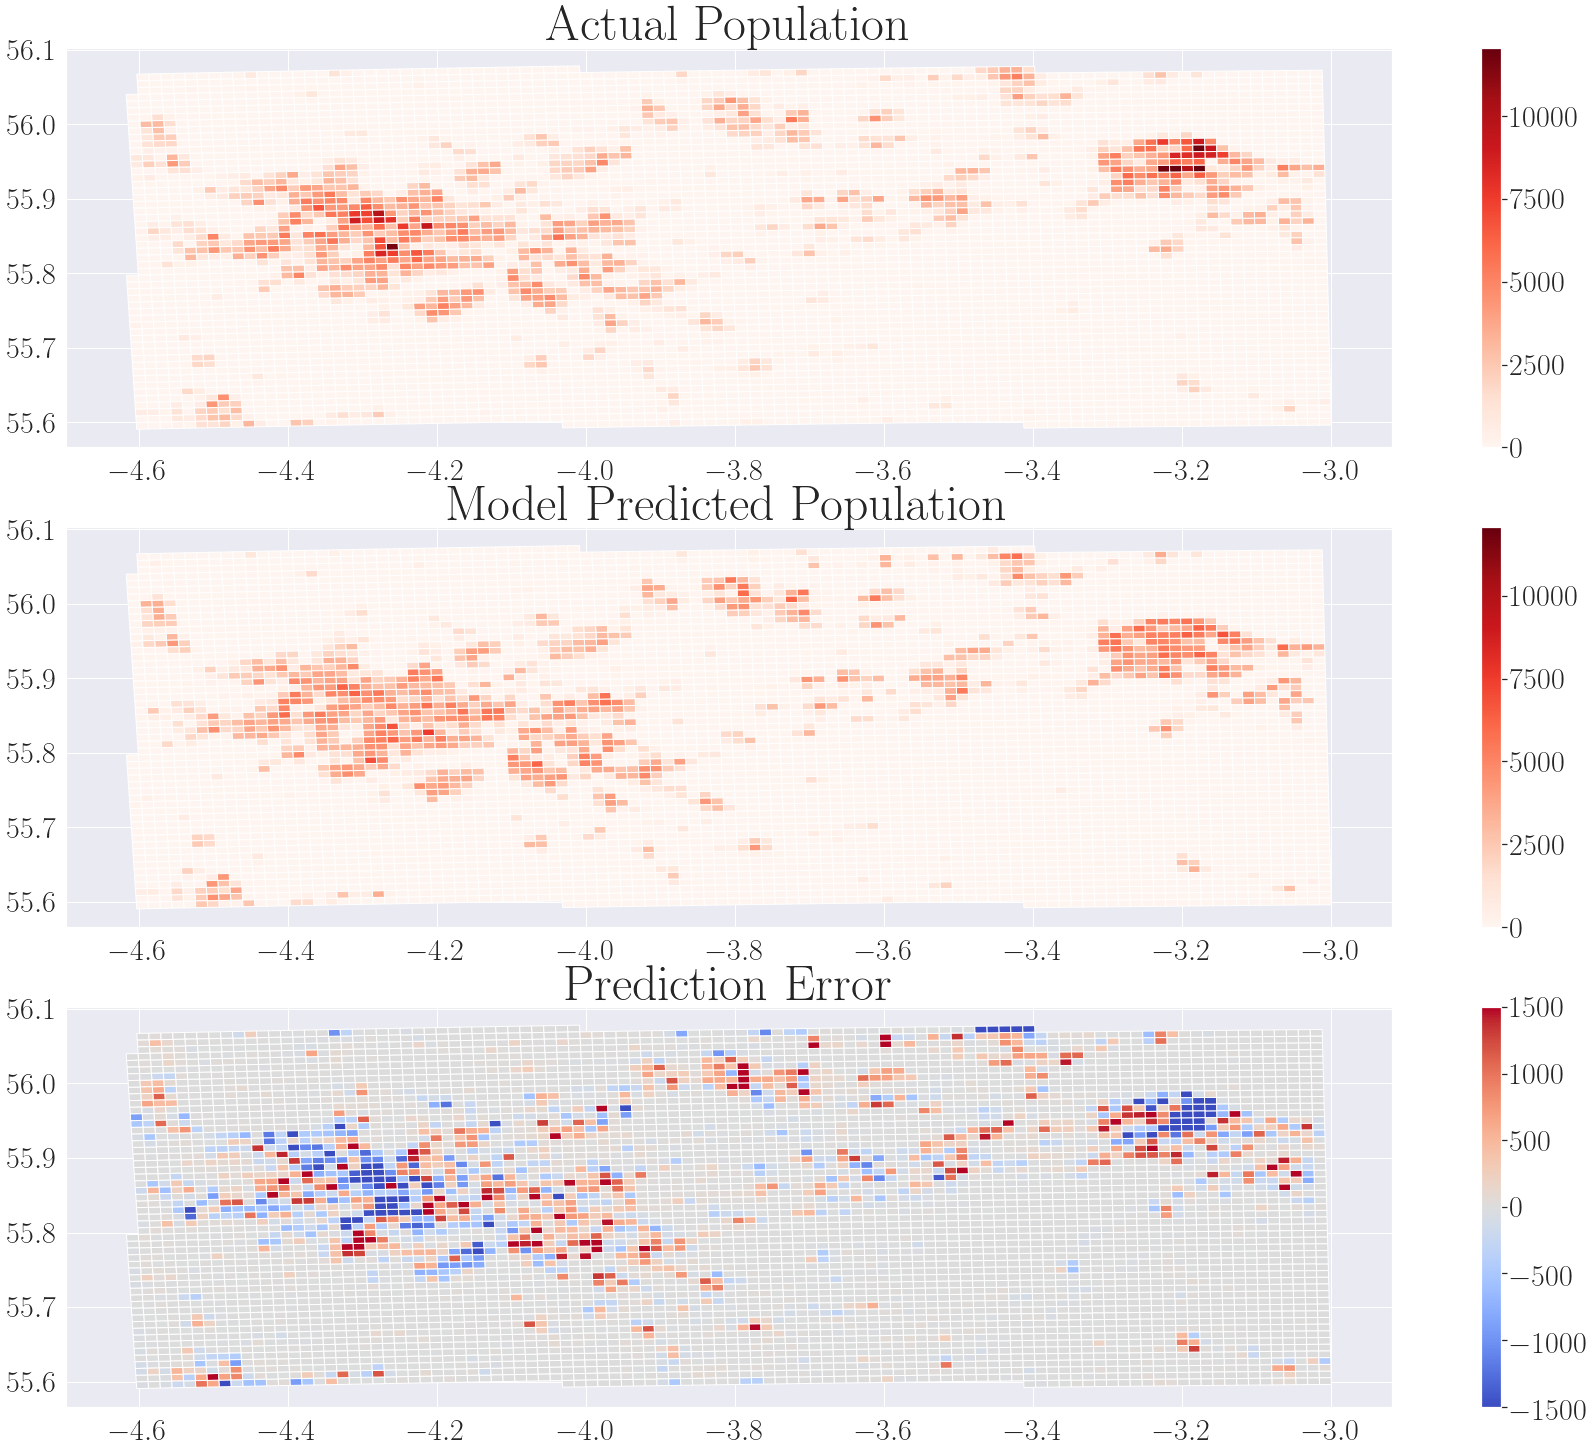

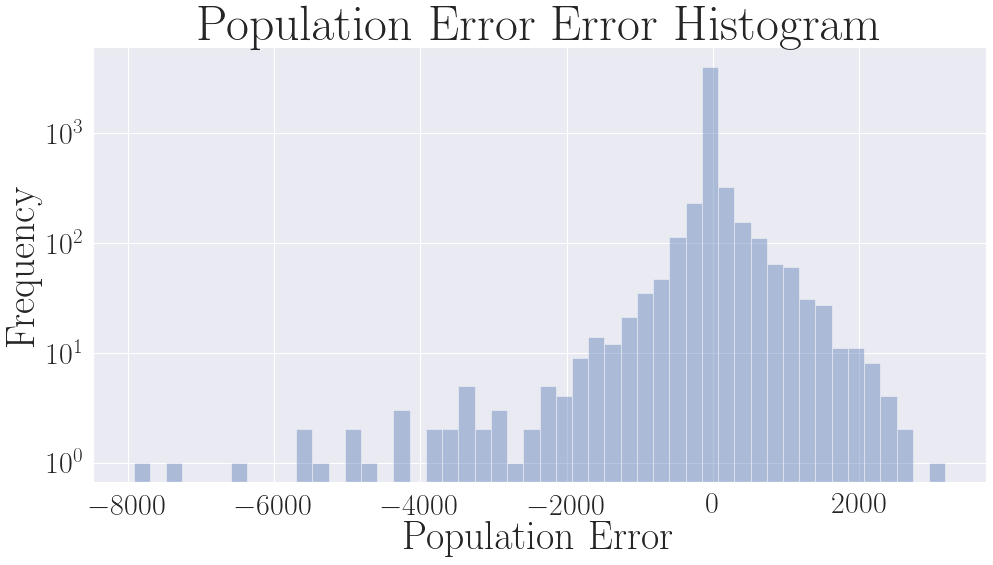

In [ ]:
# Test Region 1 - Model C
fonts(30, 40, 50)
shapefile_reg_result = shapefile_reg(results_reg_test, test_region=2)

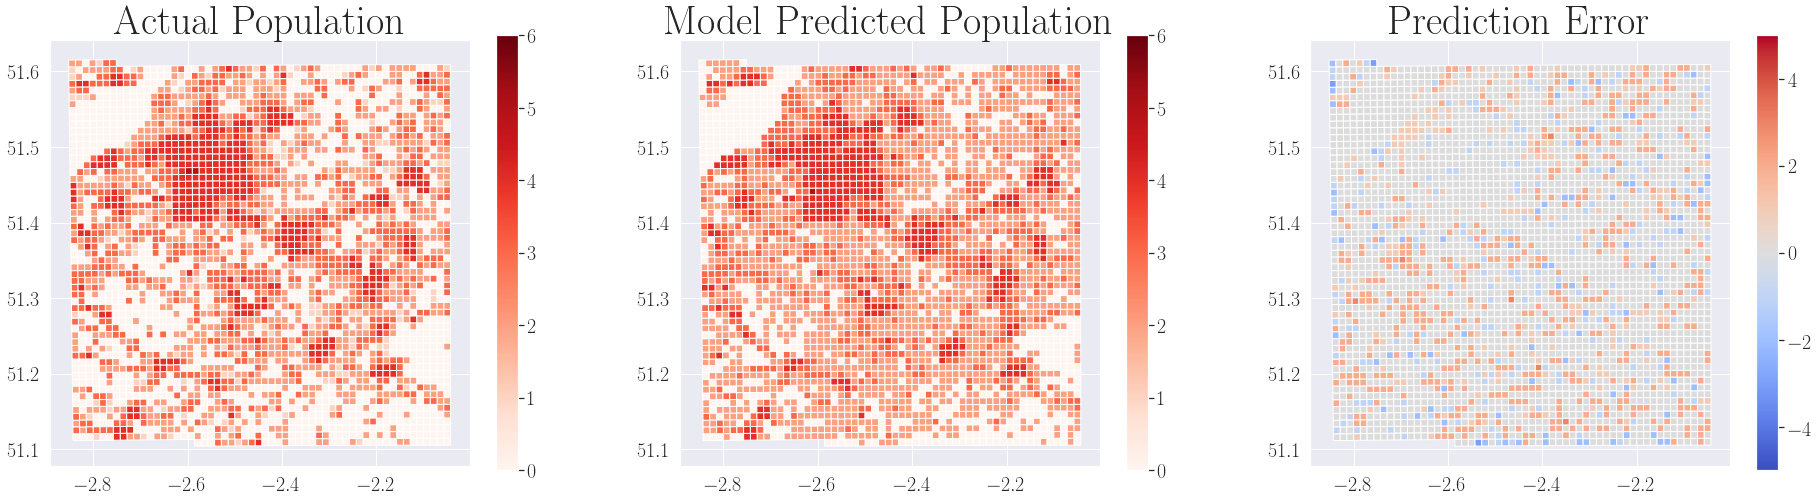

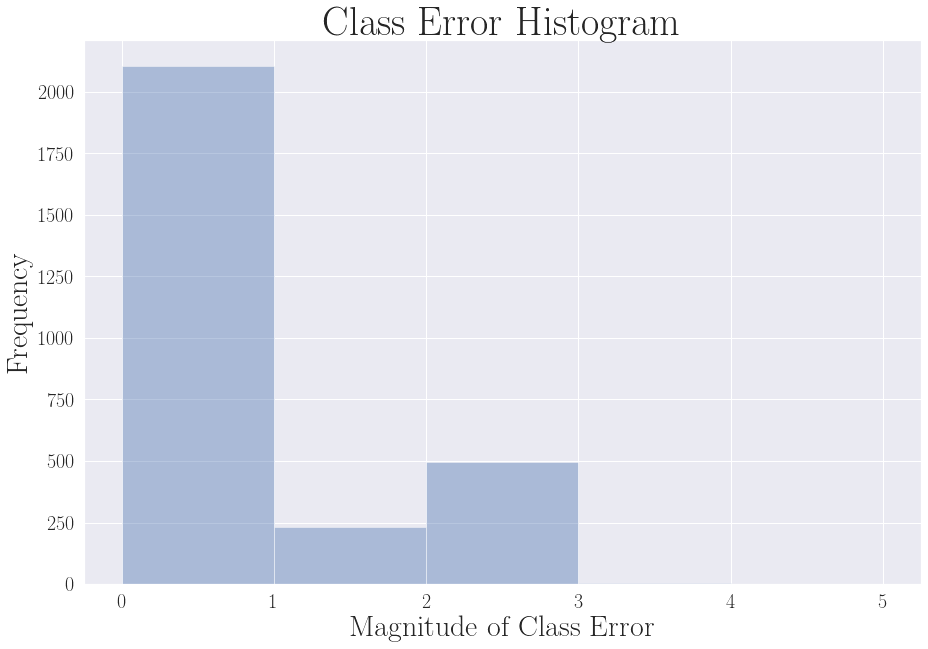

In [ ]:
# Test Region 1 - Model B
large_fonts()

shapefile_cl1 = shapefile_cl(results_cl6_test, classes=6, test_region=1)
shapefile_cl1.to_file("classification2_testset.shp")